# **Building a RNN univariate model**

In [ ]:
!pip install tensorflow --quiet
!pip install yfinance   --quiet

import math as mt
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow import keras
from seaborn import set_style
from sklearn.preprocessing import MinMaxScaler

set_style("darkgrid")

# For reproducibility
np.random.seed(24)
tf.random.set_seed(24)

In [ ]:
start_date_AAPL = "2020-06-24"
end_date_AAPL   = "2023-06-24"

start_date_AMZN = "2020-06-24"
end_date_AMZN   = "2023-06-24"

apple_ticker  = "AAPL"
amazon_ticker = "AMZN"

AAPL = yf.download(apple_ticker, start=start_date_AAPL, end=end_date_AAPL)
AMZN = yf.download(amazon_ticker, start=start_date_AMZN, end=end_date_AMZN)

# Convert index to datetime
AAPL.index = pd.to_datetime(AAPL.index)
AMZN.index = pd.to_datetime(AMZN.index)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
from sklearn.preprocessing import MinMaxScaler

AAPL_scaler = MinMaxScaler()
AMZN_scaler = MinMaxScaler()

# Reshape the data to have a shape of (-1, 1)
AAPL_close_prices = AAPL['Close'].values.reshape(-1, 1)
AMZN_close_prices = AMZN['Close'].values.reshape(-1, 1)

# Fit the scaler
AAPL_scaler.fit(AAPL_close_prices)
AMZN_scaler.fit(AMZN_close_prices)

# Apply min-max scaling
AAPL_scaled = AAPL_scaler.transform(AAPL_close_prices)
AMZN_scaled = AMZN_scaler.transform(AMZN_close_prices)

## **Creating train, validation and test dataset**

In [ ]:
def create_dataset(dataset, lookback):
    X_train = []
    Y_train = []

    for i in range(lookback, len(dataset)):
        X_train.append(dataset[i-lookback:i])
        Y_train.append(dataset[i])

    return np.array(X_train), np.array(Y_train)

In [ ]:
# Split the data into training, validation, and testing sets
AAPL_train_size = int(len(AAPL_scaled) * 0.7)
AAPL_val_size   = int(len(AAPL_scaled) * 0.2)
AAPL_train_data = AAPL_scaled[:AAPL_train_size]
AAPL_val_data   = AAPL_scaled[AAPL_train_size:AAPL_train_size + AAPL_val_size]
AAPL_test_data  = AAPL_scaled[AAPL_train_size + AAPL_val_size:]

AMZN_train_size = int(len(AMZN_scaled) * 0.7)
AMZN_val_size   = int(len(AMZN_scaled) * 0.2)
AMZN_train_data = AMZN_scaled[:AMZN_train_size]
AMZN_val_data   = AMZN_scaled[AMZN_train_size:AMZN_train_size + AMZN_val_size]
AMZN_test_data  = AMZN_scaled[AMZN_train_size + AMZN_val_size:]

In [ ]:
AAPL_X_train, AAPL_Y_train = create_dataset(AAPL_train_data, lookback=7)
AMZN_X_train, AMZN_Y_train = create_dataset(AMZN_train_data, lookback=7)

AAPL_X_val, AAPL_Y_val = create_dataset(AAPL_val_data, lookback=7)
AMZN_X_val, AMZN_Y_val = create_dataset(AMZN_val_data, lookback=7)

AAPL_X_test, AAPL_Y_test = create_dataset(AAPL_test_data, lookback=7)
AMZN_X_test, AMZN_Y_test = create_dataset(AMZN_test_data, lookback=7)

## **Close price prediction - Building the RNN** (**1st attempt**)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
lookback = 7

#################### AAPL ####################
AAPL_regressor = Sequential()

AAPL_regressor.add(SimpleRNN(units=8,
                   input_shape=(lookback, 1)))

AAPL_regressor.add(Dense(units=1))
##############################################

#################### AMZN ####################
AMZN_regressor = Sequential()

AMZN_regressor.add(SimpleRNN(units=8,
                   input_shape=(lookback, 1)))

AMZN_regressor.add(Dense(units=1))
##############################################

## **Training and evaluating the model**

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

def smape(actual, predicted):
    numerator = tf.abs(actual - predicted)
    denominator = (tf.abs(actual) + tf.abs(predicted)) / 2.0

    smape_score = tf.reduce_mean(numerator / denominator) * 100.0

    return smape_score


def compile_and_fit(model, X_train, Y_train, X_val, Y_val, file='',
                    _patience=10, _min_delta=0.0001, _epochs=100, _batch_size=32, _early_stopping=False,
                    _learning_rate=0.01, _verbose=1, _save_model=False):

    callbacks = []


    if _early_stopping:
        early_stopping = EarlyStopping(monitor='val_smape',
                                       patience=_patience,
                                       min_delta=_min_delta,
                                       mode='min')
        callbacks.append(early_stopping)


    if _save_model:
        # Define a ModelCheckpoint callback to save the best model to Google Drive
        checkpoint_path = '/content/drive/MyDrive/_Casu_Deiana/Models/' + str(file) + '.h5'
        checkpoint = ModelCheckpoint(checkpoint_path,
                                     monitor='val_smape',
                                     save_best_only=True,
                                     mode='min',
                                     verbose=_verbose)
        callbacks.append(checkpoint)


    _optimizer = Adam(learning_rate=_learning_rate)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=_optimizer,
                  metrics=[smape])


    if _verbose != 0:
        model.summary()
        plot_model(model, show_shapes=True, show_layer_names=True)


    history = model.fit(X_train, Y_train,
                        batch_size=_batch_size,
                        epochs=_epochs,
                        validation_data=(X_val, Y_val),
                        callbacks=callbacks,
                        verbose=_verbose)

    return history

Mounted at /content/drive


### **AAPL - Close price training**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
33/33 [==============================] - 2s 14ms/step - loss: 0.0393 - smape: 29.4690 - val_loss: 0.0021 - val_smape: 6.0627
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0023 - smape: 13.5558 - val_loss: 0.0017 - val_smape: 5.6150
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0014 - smape: 7.0293 - val_loss: 0.0020 - val_smape: 6.0816
Epoch 4/100
33/33 [=============================

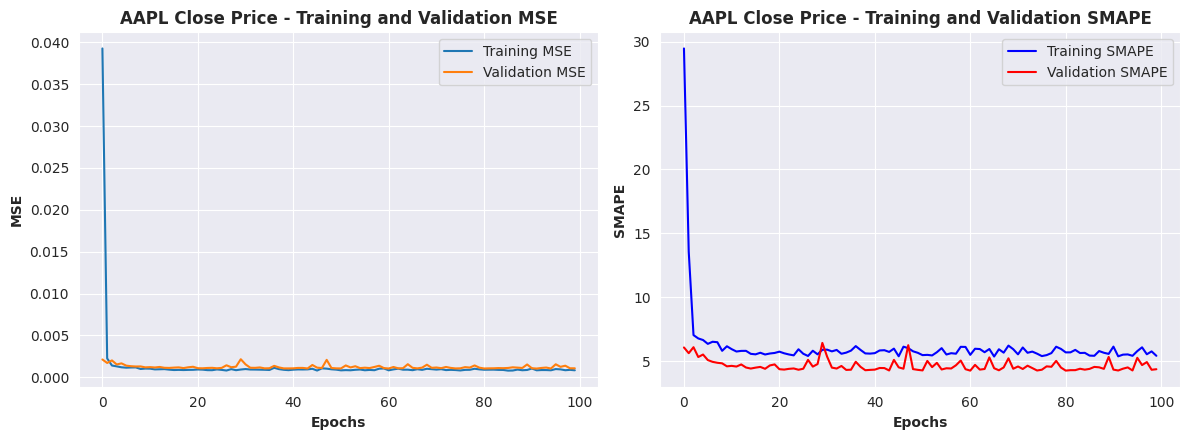

In [ ]:
history = compile_and_fit(AAPL_regressor, X_train=AAPL_X_train, Y_train=AAPL_Y_train, X_val=AAPL_X_val, Y_val=AAPL_Y_val, _batch_size=16)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot training loss and validation loss
ax1.plot(history.history['loss'], label='Training MSE')
ax1.plot(history.history['val_loss'], label='Validation MSE')
ax1.set_title('AAPL Close Price - Training and Validation MSE', fontweight='bold')
ax1.set_xlabel('Epochs', fontweight='bold')
ax1.set_ylabel('MSE', fontweight='bold')
ax1.legend()

# Plot training loss and validation smape
ax2.plot(history.history['smape'], label='Training SMAPE', color='blue')
ax2.plot(history.history['val_smape'], label='Validation SMAPE', color='red')
ax2.set_title('AAPL Close Price - Training and Validation SMAPE', fontweight='bold')
ax2.set_xlabel('Epochs', fontweight='bold')
ax2.set_ylabel('SMAPE', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
AAPL_predictions = AAPL_regressor.predict(AAPL_X_test)

# Evaluate the model on the test dataset
loss = AAPL_regressor.evaluate(AAPL_X_test, AAPL_Y_test, batch_size=32)

3/3 [==============================] - 0s 7ms/step - loss: 9.2271e-04 - smape: 3.1957


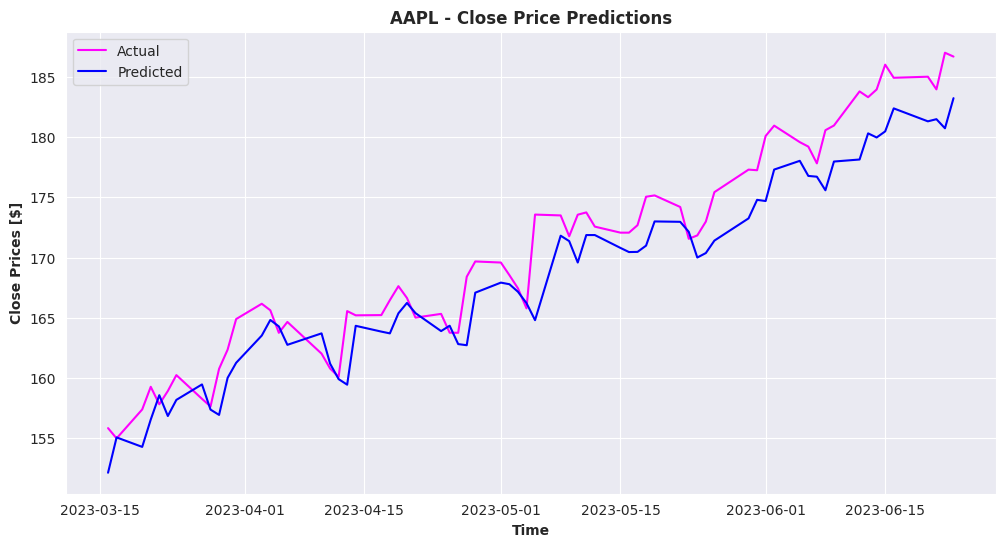

In [ ]:
# Plotting AAPL close price predictions
plt.figure(figsize=(12, 6))
plt.plot(AAPL.index[-len(AAPL_Y_test):].values, AAPL_scaler.inverse_transform(AAPL_Y_test), label='Actual', color='magenta')
plt.plot(AAPL.index[-len(AAPL_Y_test):].values, AAPL_scaler.inverse_transform(AAPL_predictions), label='Predicted', color='blue')
plt.title('AAPL - Close Price Predictions', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Close Prices [$]', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - Close price training**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
33/33 [==============================] - 2s 12ms/step - loss: 0.1720 - smape: 42.4878 - val_loss: 0.0047 - val_smape: 53.5765
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0037 - smape: 7.9037 - val_loss: 0.0033 - val_smape: 38.1259
Epoch 3/100
33/33 [==============================] - 0s 5ms/step - loss: 0.0030 - smape: 7.0451 - val_loss: 0.0026 - val_smape: 37.4539
Epoch 4/100
33/33 [=========================

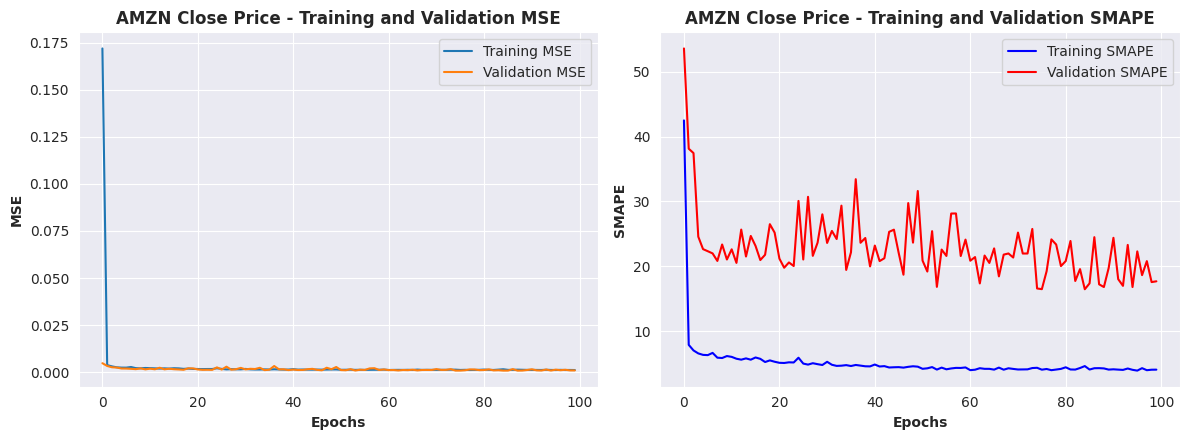

In [ ]:
history = compile_and_fit(AMZN_regressor, X_train=AMZN_X_train, Y_train=AMZN_Y_train, X_val=AMZN_X_val, Y_val=AMZN_Y_val, _batch_size=16)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot training loss and validation loss
ax1.plot(history.history['loss'], label='Training MSE')
ax1.plot(history.history['val_loss'], label='Validation MSE')
ax1.set_title('AMZN Close Price - Training and Validation MSE', fontweight='bold')
ax1.set_xlabel('Epochs', fontweight='bold')
ax1.set_ylabel('MSE', fontweight='bold')
ax1.legend()

# Plot training loss and validation smape
ax2.plot(history.history['smape'], label='Training SMAPE', color='blue')
ax2.plot(history.history['val_smape'], label='Validation SMAPE', color='red')
ax2.set_title('AMZN Close Price - Training and Validation SMAPE', fontweight='bold')
ax2.set_xlabel('Epochs', fontweight='bold')
ax2.set_ylabel('SMAPE', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
AMZN_predictions = AMZN_regressor.predict(AMZN_X_test)

# Evaluate the model on the test dataset
loss = AMZN_regressor.evaluate(AMZN_X_test, AMZN_Y_test, batch_size=32)

3/3 [==============================] - 0s 5ms/step - loss: 4.7084e-04 - smape: 6.1844


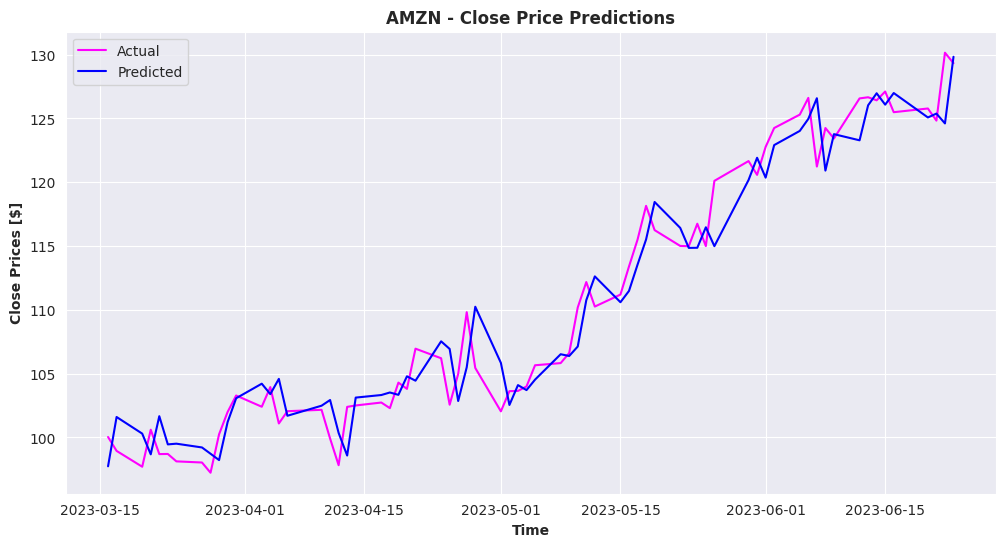

In [ ]:
# Plotting AMZN close price predictions
plt.figure(figsize=(12, 6))
plt.plot(AMZN.index[-len(AMZN_Y_test):].values, AMZN_scaler.inverse_transform(AMZN_Y_test), label='Actual', color='magenta')
plt.plot(AMZN.index[-len(AMZN_Y_test):].values, AMZN_scaler.inverse_transform(AMZN_predictions), label='Predicted', color='blue')
plt.title('AMZN - Close Price Predictions', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Close Prices [$]', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

# **Returns**

In [ ]:
from scipy import stats

T = 21

AAPL_reduced = AAPL.drop(['Open','High','Low','Adj Close','Volume'], axis=1)
AMZN_reduced = AMZN.drop(['Open','High','Low','Adj Close','Volume'], axis=1)

AAPL_returns = AAPL_reduced['Close'] - AAPL_reduced['Close'].shift(T)
AMZN_returns = AMZN_reduced['Close'] - AMZN_reduced['Close'].shift(T)

AAPL_reduced['Ret'] = AAPL_returns
AMZN_reduced['Ret'] = AMZN_returns

AAPL_reduced = AAPL_reduced.iloc[T:]
AMZN_reduced = AMZN_reduced.iloc[T:]

AAPL_mean     = AAPL_reduced['Ret'].mean()
AAPL_variance = AAPL_reduced['Ret'].var()
AAPL_std      = AAPL_reduced['Ret'].std()
AMZN_mean     = AMZN_reduced['Ret'].mean()
AMZN_variance = AMZN_reduced['Ret'].var()
AMZN_std      = AMZN_reduced['Ret'].std()

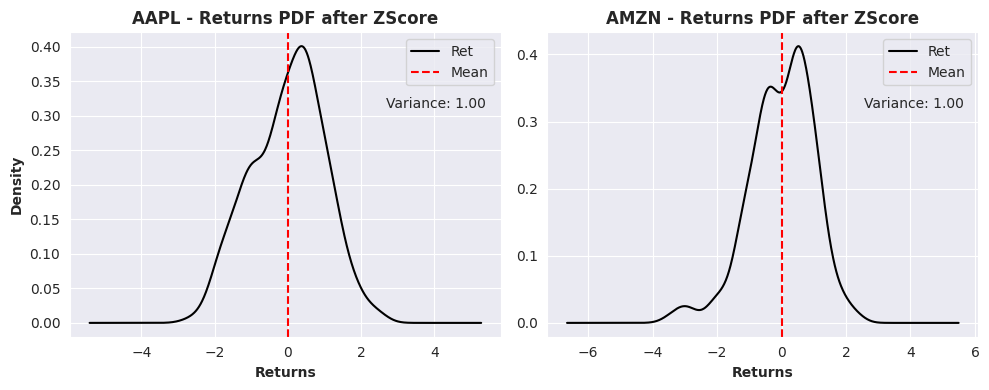

In [ ]:
# Zscore normalization
AAPL_scaled = stats.zscore(AAPL_reduced['Ret'])
AMZN_scaled = stats.zscore(AMZN_reduced['Ret'])

AAPL_mean_scaled     = AAPL_scaled.mean()
AAPL_variance_scaled = AAPL_scaled.var()
AMZN_mean_scaled     = AMZN_scaled.mean()
AMZN_variance_scaled = AMZN_scaled.var()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot PDF of AAPL scaled returns
axes[0].set_title('AAPL - Returns PDF after ZScore', fontweight='bold')
AAPL_scaled.plot.kde(ax=axes[0], color='black')
axes[0].set_xlabel('Returns', fontweight='bold')
axes[0].set_ylabel('Density', fontweight='bold')
axes[0].axvline(AAPL_mean_scaled, color='red', linestyle='--', label='Mean')
axes[0].text(0.85, 0.75, f'Variance: {AAPL_variance_scaled:.2f}', transform=axes[0].transAxes, ha='center')
axes[0].legend()

# Plot PDF of AMZN scaled returns
axes[1].set_title('AMZN - Returns PDF after ZScore', fontweight='bold')
AMZN_scaled.plot.kde(ax=axes[1], color='black')
axes[1].set_xlabel('Returns', fontweight='bold')
axes[1].set_ylabel('')
axes[1].axvline(AMZN_mean_scaled, color='red', linestyle='--', label='Mean')
axes[1].text(0.85, 0.75, f'Variance: {AMZN_variance_scaled:.2f}', transform=axes[1].transAxes, ha='center')
axes[1].legend()

plt.tight_layout()
plt.show()

## **Building a RNN model to predict Returns**

In [ ]:
# Split the data into training, validation, and testing sets
AAPL_RET_train_size = int(len(AAPL_scaled) * 0.7)
AAPL_RET_val_size   = int(len(AAPL_scaled) * 0.2)
AAPL_RET_train_data = AAPL_scaled[:AAPL_RET_train_size]
AAPL_RET_val_data   = AAPL_scaled[AAPL_RET_train_size:AAPL_RET_train_size + AAPL_RET_val_size]
AAPL_RET_test_data  = AAPL_scaled[AAPL_RET_train_size + AAPL_RET_val_size:]

AMZN_RET_train_size = int(len(AAPL_scaled) * 0.7)
AMZN_RET_val_size   = int(len(AAPL_scaled) * 0.2)
AMZN_RET_train_data = AMZN_scaled[:AMZN_RET_train_size]
AMZN_RET_val_data   = AMZN_scaled[AMZN_RET_train_size:AMZN_RET_train_size + AMZN_RET_val_size]
AMZN_RET_test_data  = AMZN_scaled[AMZN_RET_train_size + AMZN_RET_val_size:]

In [ ]:
AAPL_RET_X_train, AAPL_RET_Y_train = create_dataset(AAPL_RET_train_data, lookback=7)
AMZN_RET_X_train, AMZN_RET_Y_train = create_dataset(AMZN_RET_train_data, lookback=7)

AAPL_RET_X_val, AAPL_RET_Y_val = create_dataset(AAPL_RET_val_data, lookback=7)
AMZN_RET_X_val, AMZN_RET_Y_val = create_dataset(AMZN_RET_val_data, lookback=7)

AAPL_RET_X_test, AAPL_RET_Y_test = create_dataset(AAPL_RET_test_data, lookback=7)
AMZN_RET_X_test, AMZN_RET_Y_test = create_dataset(AMZN_RET_test_data, lookback=7)

In [ ]:
#################### AAPL ####################
AAPL_RET_regressor = Sequential()

AAPL_RET_regressor.add(SimpleRNN(units=8,
                   input_shape=(7, 1)))

AAPL_RET_regressor.add(Dense(units=1))
##############################################

#################### AMZN ####################
AMZN_RET_regressor = Sequential()

AMZN_RET_regressor.add(SimpleRNN(units=8,
                   input_shape=(7, 1)))

AMZN_RET_regressor.add(Dense(units=1))
##############################################

## **Training and evaluating the model - (AAPL - 1st attempt)**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 1s 24ms/step - loss: 1.0313 - smape: 122.5292 - val_loss: 0.4560 - val_smape: 77.9991
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3285 - smape: 78.2440 - val_loss: 0.3309 - val_smape: 79.5205
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2184 - smape: 69.7227 - val_loss: 0.2567 - val_smape: 75.7732
Epoch 4/100
16/16 [======================

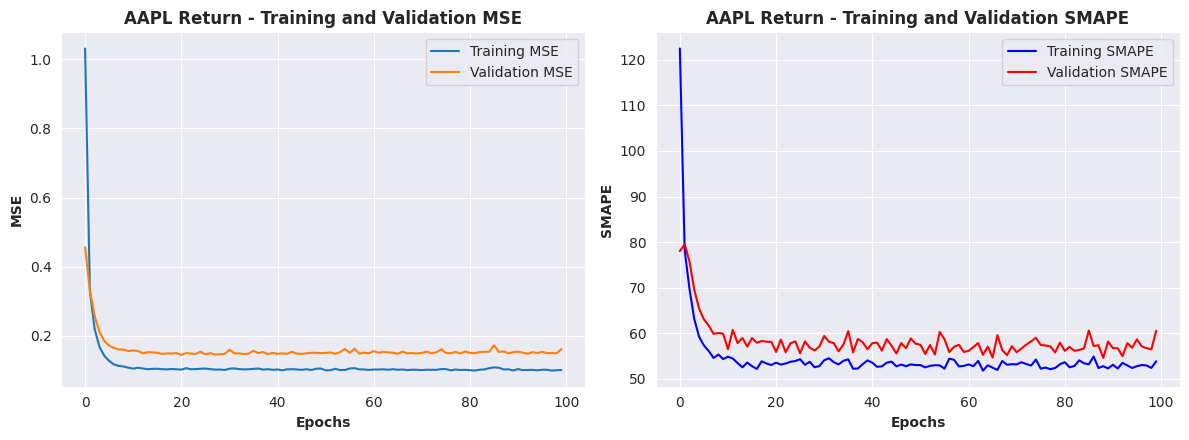

In [ ]:
history = compile_and_fit(AAPL_RET_regressor, AAPL_RET_X_train, AAPL_RET_Y_train, AAPL_RET_X_val, AAPL_RET_Y_val)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot training loss and validation loss
ax1.plot(history.history['loss'], label='Training MSE')
ax1.plot(history.history['val_loss'], label='Validation MSE')
ax1.set_title('AAPL Return - Training and Validation MSE', fontweight='bold')
ax1.set_xlabel('Epochs', fontweight='bold')
ax1.set_ylabel('MSE', fontweight='bold')
ax1.legend()

# Plot training loss and validation smape
ax2.plot(history.history['smape'], label='Training SMAPE', color='blue')
ax2.plot(history.history['val_smape'], label='Validation SMAPE', color='red')
ax2.set_title('AAPL Return - Training and Validation SMAPE', fontweight='bold')
ax2.set_xlabel('Epochs', fontweight='bold')
ax2.set_ylabel('SMAPE', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
AAPL_RET_predictions = AAPL_RET_regressor.predict(AAPL_RET_X_test)
loss = AAPL_RET_regressor.evaluate(AAPL_RET_X_test, AAPL_RET_Y_test, batch_size=32)

3/3 [==============================] - 0s 7ms/step - loss: 0.0713 - smape: 39.6332


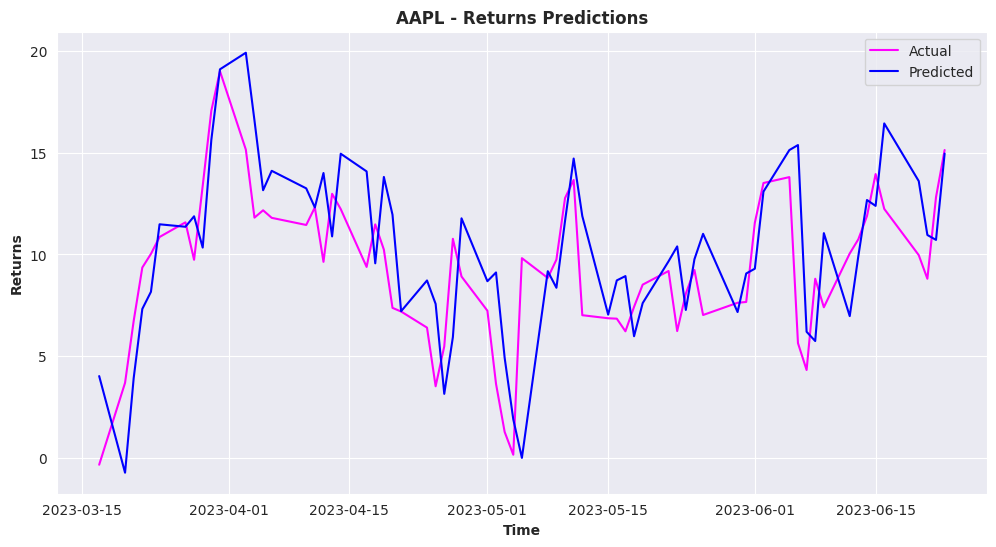

In [ ]:
# Inverse transform AAPL Returns
AAPL_test = (AAPL_RET_Y_test * AAPL_std) + AAPL_mean
AAPL_predictions = (AAPL_RET_predictions * AAPL_std) + AAPL_mean

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

## **Training and evaluating the model** (**AMZN** - **1st attempt**)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 2s 36ms/step - loss: 0.5210 - smape: 95.8422 - val_loss: 0.1274 - val_smape: 57.3983
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.1818 - smape: 62.8880 - val_loss: 0.1080 - val_smape: 52.0914
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.1534 - smape: 60.3908 - val_loss: 0.0956 - val_smape: 51.9786
Epoch 4/100
16/16 [======================

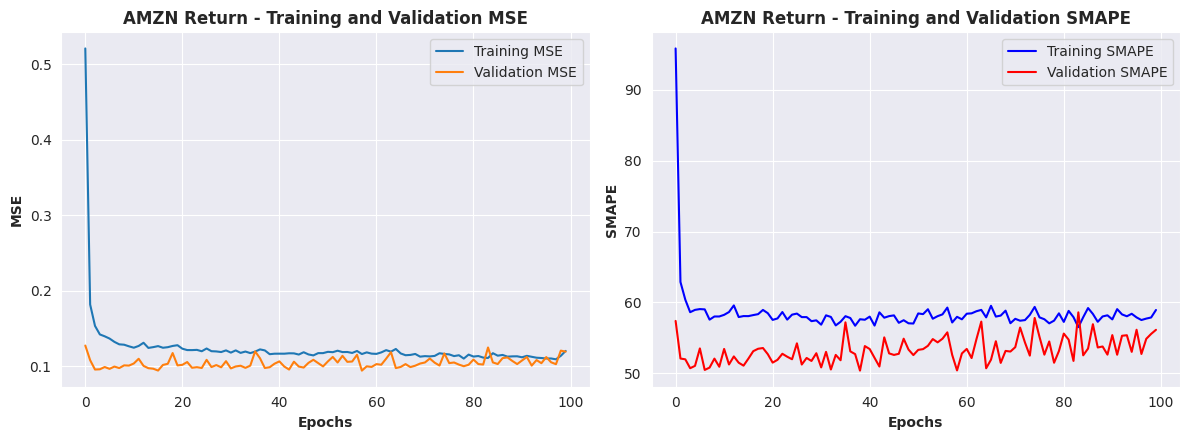

In [ ]:
history = compile_and_fit(AMZN_RET_regressor, AMZN_RET_X_train, AMZN_RET_Y_train, AMZN_RET_X_val, AMZN_RET_Y_val)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot training loss and validation loss
ax1.plot(history.history['loss'], label='Training MSE')
ax1.plot(history.history['val_loss'], label='Validation MSE')
ax1.set_title('AMZN Return - Training and Validation MSE', fontweight='bold')
ax1.set_xlabel('Epochs', fontweight='bold')
ax1.set_ylabel('MSE', fontweight='bold')
ax1.legend()

# Plot training loss and validation smape
ax2.plot(history.history['smape'], label='Training SMAPE', color='blue')
ax2.plot(history.history['val_smape'], label='Validation SMAPE', color='red')
ax2.set_title('AMZN Return - Training and Validation SMAPE', fontweight='bold')
ax2.set_xlabel('Epochs', fontweight='bold')
ax2.set_ylabel('SMAPE', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
AMZN_RET_predictions = AMZN_RET_regressor.predict(AMZN_RET_X_test)
loss = AMZN_RET_regressor.evaluate(AMZN_RET_X_test, AMZN_RET_Y_test, batch_size=32)

3/3 [==============================] - 0s 6ms/step - loss: 0.0638 - smape: 35.8544


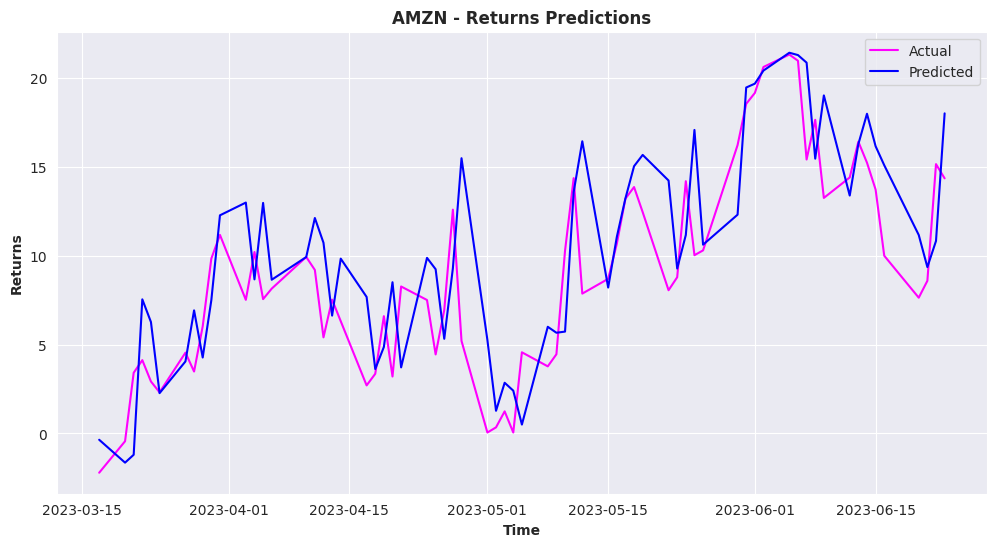

In [ ]:
# Inverse transform AMZN Returns
AMZN_test = (AMZN_RET_Y_test * AMZN_std) + AMZN_mean
AMZN_predictions = (AMZN_RET_predictions * AMZN_std) + AMZN_mean

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

## **Training and evaluating the model** (**Moving Average**)

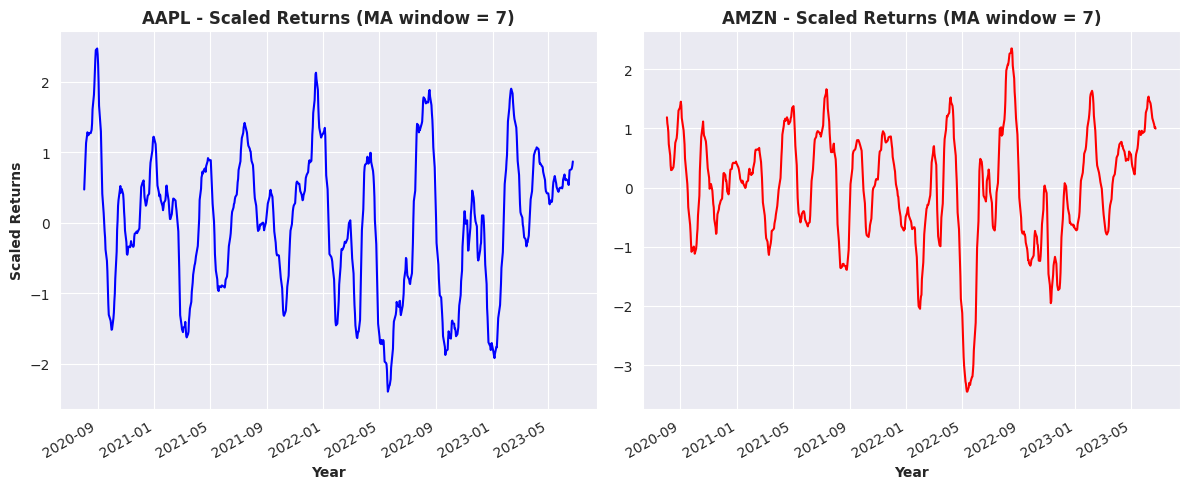

In [ ]:
window_size = 7
AAPL_RET_MA = AAPL_reduced['Ret'].rolling(window=window_size).mean()
AMZN_RET_MA = AMZN_reduced['Ret'].rolling(window=window_size).mean()

# Drop missing values from the moving average series
AAPL_RET_MA = AAPL_RET_MA.dropna()
AMZN_RET_MA = AMZN_RET_MA.dropna()

AAPL_mean_MA     = AAPL_RET_MA.mean()
AAPL_variance_MA = AAPL_RET_MA.var()
AAPL_std_MA      = AAPL_RET_MA.std()
AMZN_mean_MA     = AMZN_RET_MA.mean()
AMZN_variance_MA = AMZN_RET_MA.var()
AMZN_std_MA      = AMZN_RET_MA.std()

################################################################################

# Zscore normalization
AAPL_RET_MA_scaled = stats.zscore(AAPL_RET_MA)
AMZN_RET_MA_scaled = stats.zscore(AMZN_RET_MA)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title('AAPL - Scaled Returns (MA window = ' + str(window_size) + ')', fontweight='bold')
AAPL_RET_MA_scaled.plot(ax=axes[0], color='blue')
axes[0].set_xlabel('Year', fontweight='bold')
axes[0].set_ylabel('Scaled Returns', fontweight='bold')

axes[1].set_title('AMZN - Scaled Returns (MA window = ' + str(window_size) + ')', fontweight='bold')
AMZN_RET_MA_scaled.plot(ax=axes[1], color='red')
axes[1].set_xlabel('Year', fontweight='bold')

plt.tight_layout()
plt.show()

## **Creating train, validation and test dataset**

In [ ]:
# Split the data into training, validation, and testing sets
AAPL_RET_MA_train_size = int(len(AAPL_RET_MA_scaled) * 0.7)
AAPL_RET_MA_val_size   = int(len(AAPL_RET_MA_scaled) * 0.2)
AAPL_RET_MA_train_data = AAPL_RET_MA_scaled[:AAPL_RET_MA_train_size]
AAPL_RET_MA_val_data   = AAPL_RET_MA_scaled[AAPL_RET_MA_train_size:AAPL_RET_MA_train_size + AAPL_RET_MA_val_size]
AAPL_RET_MA_test_data  = AAPL_RET_MA_scaled[AAPL_RET_MA_train_size + AAPL_RET_MA_val_size:]

AMZN_RET_MA_train_size = int(len(AMZN_RET_MA_scaled) * 0.7)
AMZN_RET_MA_val_size   = int(len(AMZN_RET_MA_scaled) * 0.2)
AMZN_RET_MA_train_data = AMZN_RET_MA_scaled[:AMZN_RET_MA_train_size]
AMZN_RET_MA_val_data   = AMZN_RET_MA_scaled[AMZN_RET_MA_train_size:AMZN_RET_MA_train_size + AMZN_RET_MA_val_size]
AMZN_RET_MA_test_data  = AMZN_RET_MA_scaled[AMZN_RET_MA_train_size + AMZN_RET_MA_val_size:]

In [ ]:
AAPL_RET_MA_X_train, AAPL_RET_MA_Y_train = create_dataset(AAPL_RET_MA_train_data, lookback=7)
AMZN_RET_MA_X_train, AMZN_RET_MA_Y_train = create_dataset(AMZN_RET_MA_train_data, lookback=7)

AAPL_RET_MA_X_val, AAPL_RET_MA_Y_val = create_dataset(AAPL_RET_MA_val_data, lookback=7)
AMZN_RET_MA_X_val, AMZN_RET_MA_Y_val = create_dataset(AMZN_RET_MA_val_data, lookback=7)

AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test = create_dataset(AAPL_RET_MA_test_data, lookback=7)
AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test = create_dataset(AMZN_RET_MA_test_data, lookback=7)

In [ ]:
############### AAPL - RET_MA ############
AAPL_RET_MA_regressor = Sequential()

AAPL_RET_MA_regressor.add(SimpleRNN(units=8,
                   input_shape=(7, 1)))

AAPL_RET_MA_regressor.add(Dense(units=1))
##########################################

############### AMZN - RET_MA ############
AMZN_RET_MA_regressor = Sequential()

AMZN_RET_MA_regressor.add(SimpleRNN(units=8,
                   input_shape=(7, 1)))

AMZN_RET_MA_regressor.add(Dense(units=1))
##########################################

### **AAPL**

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 3s 50ms/step - loss: 0.6304 - smape: 101.6801 - val_loss: 0.1302 - val_smape: 60.9327
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0570 - smape: 38.3170 - val_loss: 0.0453 - val_smape: 51.2340
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0291 - smape: 35.0809 - val_loss: 0.0402 - val_smape: 47.5505
Epoch 4/100
16/16 [====================

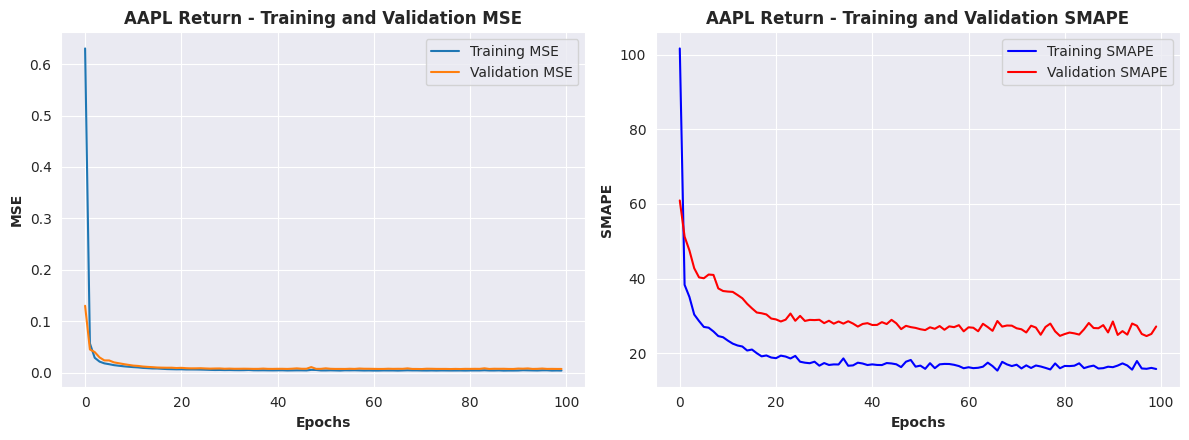

In [ ]:
history = compile_and_fit(AAPL_RET_MA_regressor, X_train=AAPL_RET_MA_X_train, Y_train=AAPL_RET_MA_Y_train, X_val=AAPL_RET_MA_X_val, Y_val=AAPL_RET_MA_Y_val)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot training loss and validation loss
ax1.plot(history.history['loss'], label='Training MSE')
ax1.plot(history.history['val_loss'], label='Validation MSE')
ax1.set_title('AAPL Return - Training and Validation MSE', fontweight='bold')
ax1.set_xlabel('Epochs', fontweight='bold')
ax1.set_ylabel('MSE', fontweight='bold')
ax1.legend()

# Plot training loss and validation smape
ax2.plot(history.history['smape'], label='Training SMAPE', color='blue')
ax2.plot(history.history['val_smape'], label='Validation SMAPE', color='red')
ax2.set_title('AAPL Return - Training and Validation SMAPE', fontweight='bold')
ax2.set_xlabel('Epochs', fontweight='bold')
ax2.set_ylabel('SMAPE', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
AAPL_RET_MA_predictions = AAPL_RET_MA_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_8, AAPL_smape_8 = AAPL_RET_MA_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 6ms/step - loss: 0.0025 - smape: 7.3684


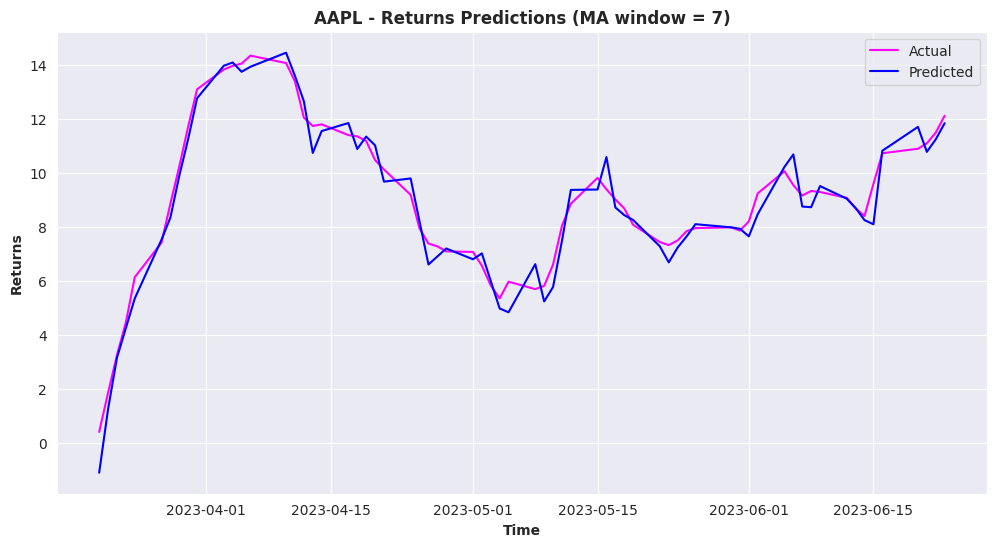

In [ ]:
# Inverse transform AAPL Returns
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_MA_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ')', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN**

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 1s 24ms/step - loss: 0.3656 - smape: 73.2542 - val_loss: 0.0542 - val_smape: 46.6426
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.1077 - smape: 36.4721 - val_loss: 0.0218 - val_smape: 30.6276
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0417 - smape: 31.1019 - val_loss: 0.0119 - val_smape: 25.3178
Epoch 4/100
16/16 [=======================

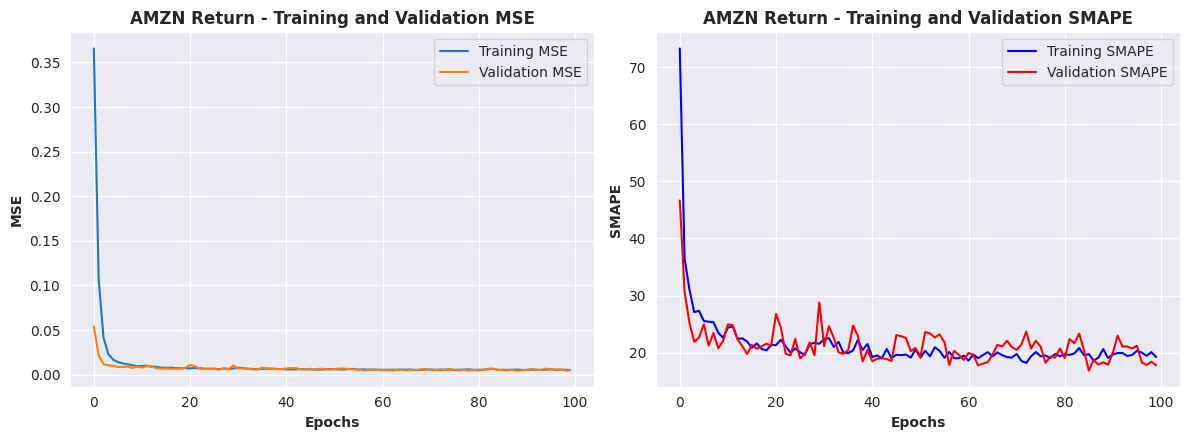

In [ ]:
history = compile_and_fit(AMZN_RET_MA_regressor, X_train=AMZN_RET_MA_X_train, Y_train=AMZN_RET_MA_Y_train, X_val=AMZN_RET_MA_X_val, Y_val=AMZN_RET_MA_Y_val)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot training loss and validation loss
ax1.plot(history.history['loss'], label='Training MSE')
ax1.plot(history.history['val_loss'], label='Validation MSE')
ax1.set_title('AMZN Return - Training and Validation MSE', fontweight='bold')
ax1.set_xlabel('Epochs', fontweight='bold')
ax1.set_ylabel('MSE', fontweight='bold')
ax1.legend()

# Plot training loss and validation smape
ax2.plot(history.history['smape'], label='Training SMAPE', color='blue')
ax2.plot(history.history['val_smape'], label='Validation SMAPE', color='red')
ax2.set_title('AMZN Return - Training and Validation SMAPE', fontweight='bold')
ax2.set_xlabel('Epochs', fontweight='bold')
ax2.set_ylabel('SMAPE', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
AMZN_RET_MA_predictions = AMZN_RET_MA_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_8, AMZN_smape_8 = AMZN_RET_MA_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 5ms/step - loss: 0.0026 - smape: 9.2658


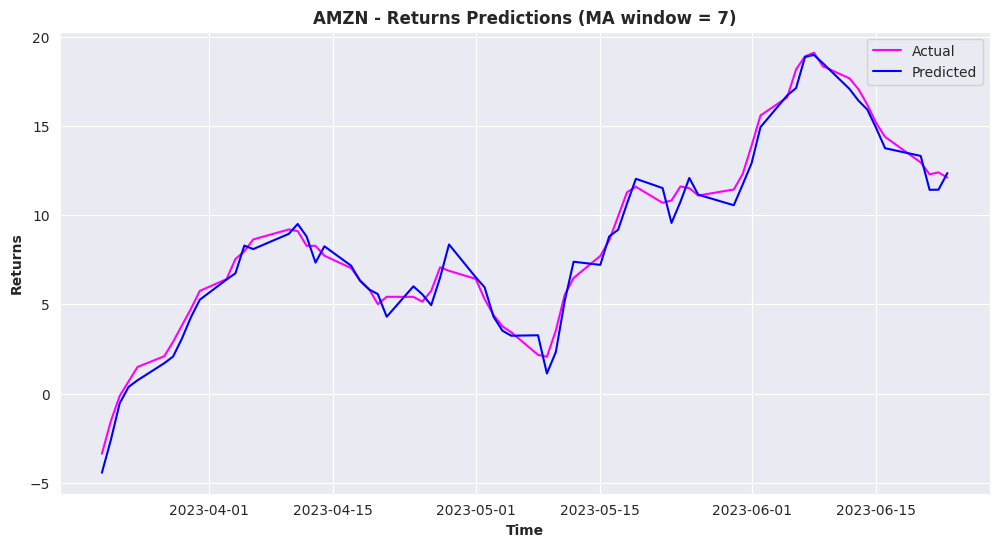

In [ ]:
# Inverse transform AAPL Returns
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_MA_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ')', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

# **Improving perfomance**

## **Increasing the number of units**
Increasing the number of neurons can help the model capture more complex patterns in the data, but can also increase the risk of overfitting.

### **AAPL - 16 units**

In [ ]:
batch_size = 32

############### AAPL - RET_MA ###############
AAPL_RET_16_regressor = Sequential()

AAPL_RET_16_regressor.add(SimpleRNN(units=16,
                            batch_input_shape=(batch_size, 7, 1)))

AAPL_RET_16_regressor.add(Dense(units=1))
##########################################

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (32, 16)                  288       
                                                                 
 dense_6 (Dense)             (32, 1)                   17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 2s 24ms/step - loss: 0.0400 - smape: 38.3111 - val_loss: 0.0333 - val_smape: 37.8304
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0135 - smape: 24.0352 - val_loss: 0.0167 - val_smape: 32.3185
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0093 - smape: 21.3430 - val_loss: 0.0124 - val_smape: 35.7501
Epoch 4/100
16/16 [=====================

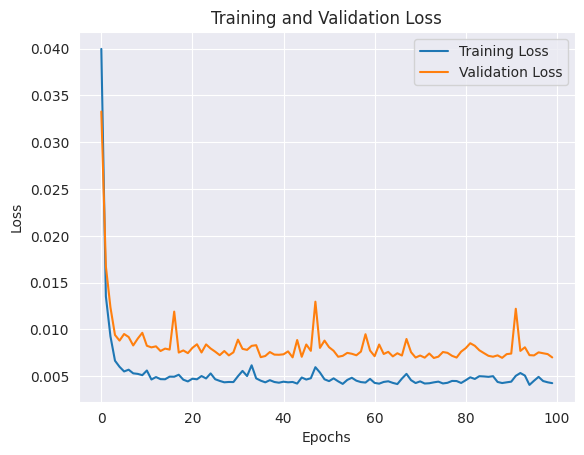

In [ ]:
history = compile_and_fit(AAPL_RET_16_regressor, X_train=AAPL_RET_MA_X_train, Y_train=AAPL_RET_MA_Y_train, X_val=AAPL_RET_MA_X_val, Y_val=AAPL_RET_MA_Y_val)

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AAPL_RET_16_predictions = AAPL_RET_16_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_16, AAPL_smape_16  = AAPL_RET_16_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 7ms/step - loss: 0.0025 - smape: 7.6621


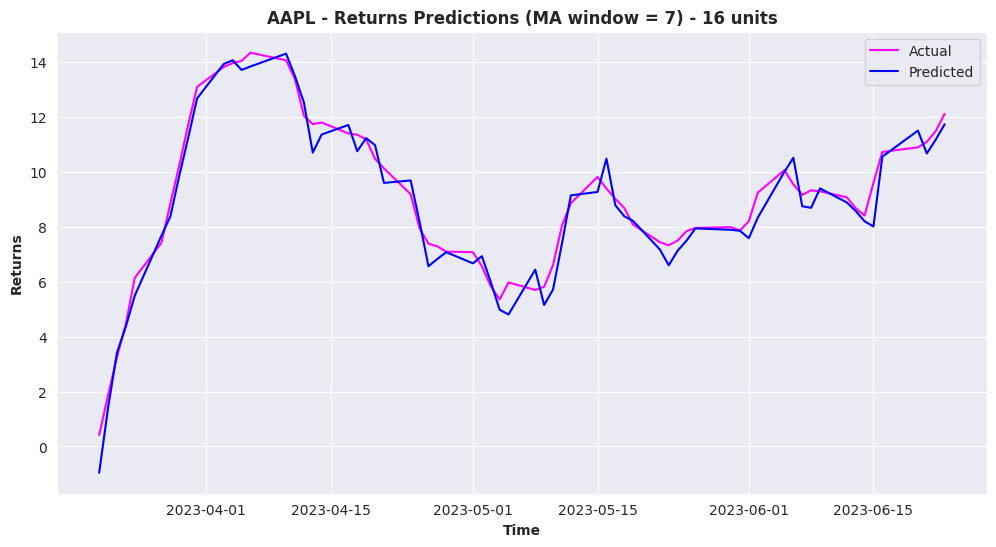

In [ ]:
# Inverse transform AAPL Returns
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_16_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 16 units', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 16 units**

In [ ]:
batch_size = 32

############### AMZN - LOGRET_MA ###############
AMZN_RET_16_regressor = Sequential()

AMZN_RET_16_regressor.add(SimpleRNN(units=16,
                            batch_input_shape=(batch_size, 7, 1)))

AMZN_RET_16_regressor.add(Dense(units=1))
##########################################

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (32, 16)                  288       
                                                                 
 dense_7 (Dense)             (32, 1)                   17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 5s 68ms/step - loss: 0.3616 - smape: 76.5883 - val_loss: 0.0400 - val_smape: 39.7805
Epoch 2/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0439 - smape: 35.5750 - val_loss: 0.0281 - val_smape: 31.4833
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0213 - smape: 30.0659 - val_loss: 0.0127 - val_smape: 27.2248
Epoch 4/100
16/16 [===================

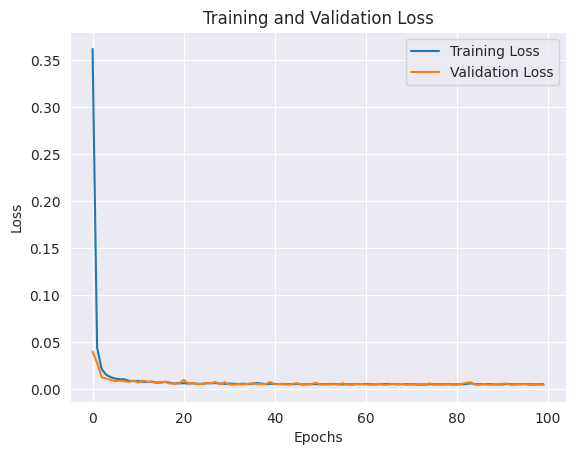

In [ ]:
history = compile_and_fit(AMZN_RET_16_regressor, X_train=AMZN_RET_MA_X_train, Y_train=AMZN_RET_MA_Y_train, X_val=AMZN_RET_MA_X_val, Y_val=AMZN_RET_MA_Y_val)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AMZN_RET_16_predictions = AMZN_RET_16_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_16, AMZN_smape_16  = AMZN_RET_16_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 9ms/step - loss: 0.0026 - smape: 8.4374


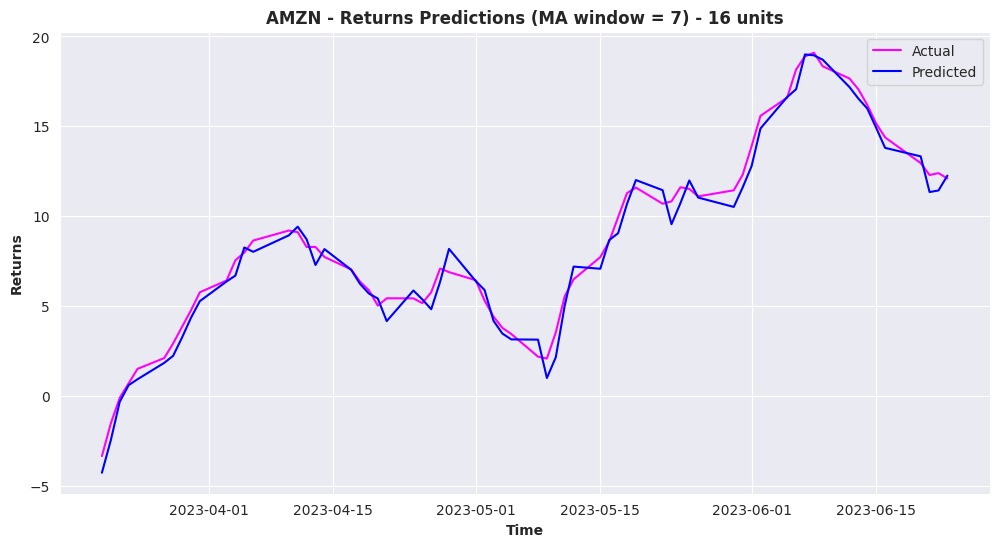

In [ ]:
# Inverse transform AMZN Returns
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_16_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 16 units', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AAPL - 32 units**

In [ ]:
batch_size = 32

############### AAPL - LOGRET_MA ###############
AAPL_RET_32_regressor = Sequential()

AAPL_RET_32_regressor.add(SimpleRNN(units=32,
                            batch_input_shape=(batch_size, 7, 1)))

AAPL_RET_32_regressor.add(Dense(units=1))
##########################################

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (32, 32)                  1088      
                                                                 
 dense_8 (Dense)             (32, 1)                   33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 3s 70ms/step - loss: 0.1001 - smape: 49.7719 - val_loss: 0.0569 - val_smape: 43.5845
Epoch 2/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0229 - smape: 29.0564 - val_loss: 0.0271 - val_smape: 41.7038
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0120 - smape: 24.1884 - val_loss: 0.0155 - val_smape: 37.4298
Epoch 4/100
16/16 [===============

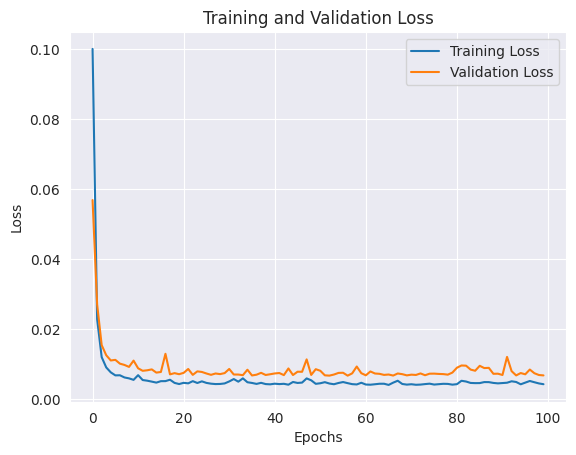

In [ ]:
history = compile_and_fit(AAPL_RET_32_regressor, AAPL_RET_MA_X_train, AAPL_RET_MA_Y_train, AAPL_RET_MA_X_val, AAPL_RET_MA_Y_val)

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AAPL_RET_32_predictions = AAPL_RET_32_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_32, AAPL_smape_32  = AAPL_RET_32_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 6ms/step - loss: 0.0031 - smape: 9.0975


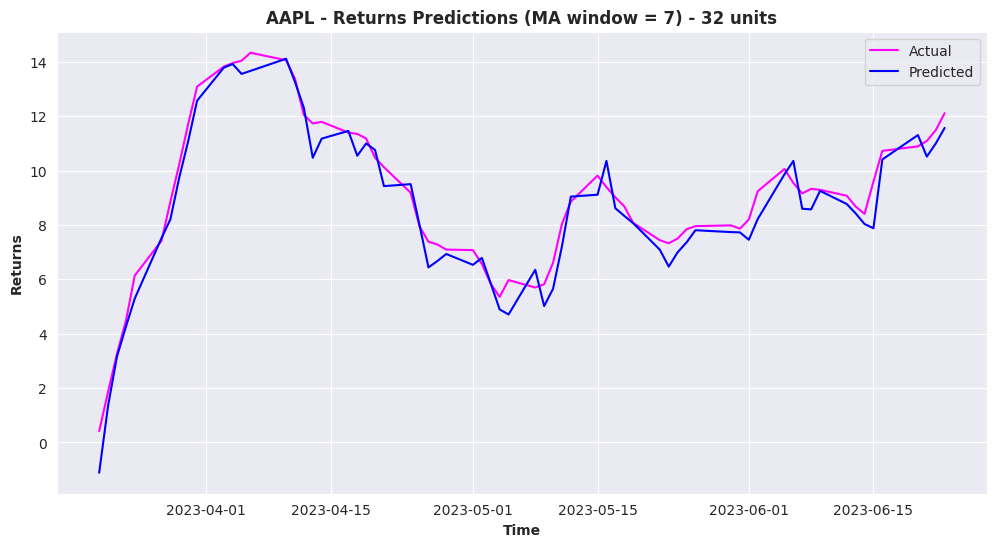

In [ ]:
# Inverse transform AAPL Returns
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_32_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 32 units', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 32 units**

In [ ]:
batch_size = 32

############### AMZN - LOGRET_MA ###############
AMZN_RET_32_regressor = Sequential()

AMZN_RET_32_regressor.add(SimpleRNN(units=32,
                            batch_input_shape=(batch_size, 7, 1)))

AMZN_RET_32_regressor.add(Dense(units=1))
##########################################

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (32, 32)                  1088      
                                                                 
 dense_9 (Dense)             (32, 1)                   33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 1s 25ms/step - loss: 0.1214 - smape: 57.6428 - val_loss: 0.0289 - val_smape: 36.2467
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0187 - smape: 30.3989 - val_loss: 0.0152 - val_smape: 32.6892
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0109 - smape: 24.9907 - val_loss: 0.0084 - val_smape: 23.1925
Epoch 4/100
16/16 [=================

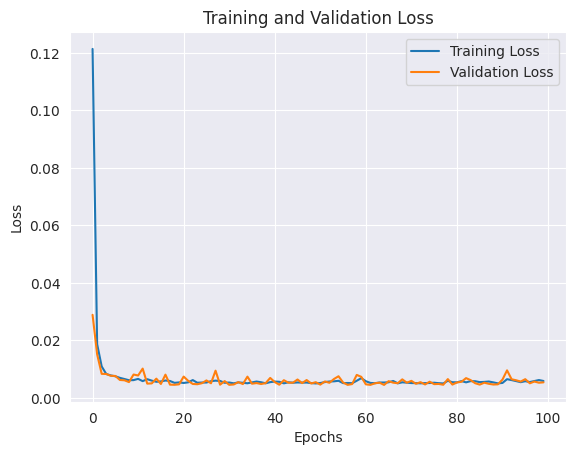

In [ ]:
history = compile_and_fit(AMZN_RET_32_regressor, X_train=AMZN_RET_MA_X_train, Y_train=AMZN_RET_MA_Y_train, X_val=AMZN_RET_MA_X_val, Y_val=AMZN_RET_MA_Y_val)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AMZN_RET_32_predictions = AMZN_RET_32_regressor.predict(AMZN_RET_MA_X_test)

# Evaluate the model on the test dataset
AMZN_loss_32, AMZN_smape_32  = AMZN_RET_32_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 7ms/step - loss: 0.0027 - smape: 9.1711


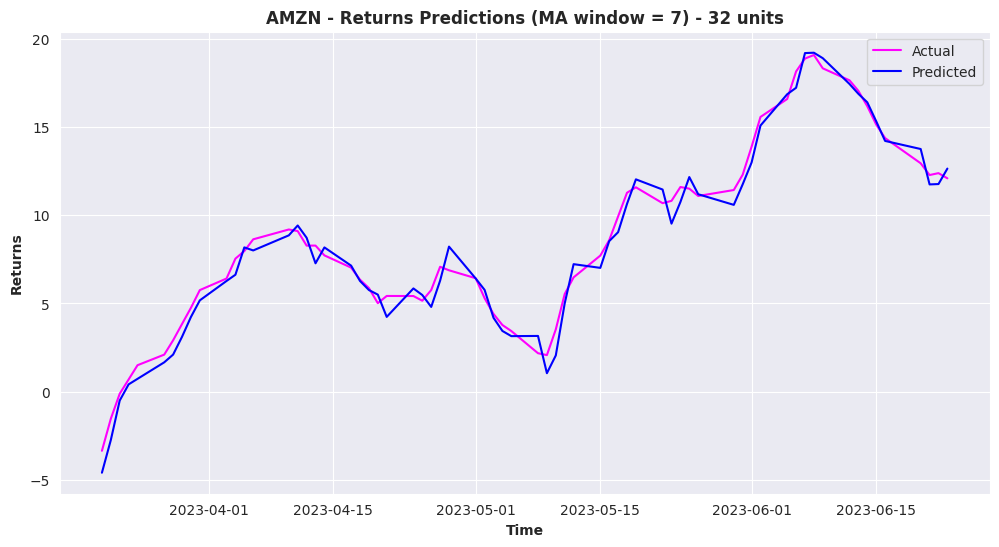

In [ ]:
# Inverse transform AMZN Returns
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_32_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 32 units', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

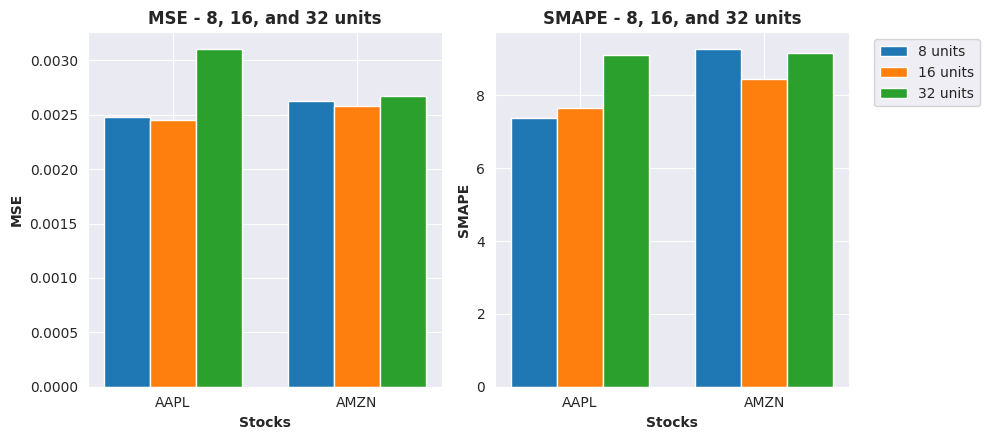

In [ ]:
labels = ['AAPL', 'AMZN']
x = np.arange(len(labels))

loss_values = np.array([[AAPL_loss_8, AAPL_loss_16, AAPL_loss_32],    [AMZN_loss_8, AMZN_loss_16, AMZN_loss_32]])
smape_values  = np.array([[AAPL_smape_8, AAPL_smape_16, AAPL_smape_32],[AMZN_smape_8, AMZN_smape_16, AMZN_smape_32 ]])

fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))

# Plotting the loss bar chart
axs[0].bar(x, loss_values[:, 0], width=0.25, align='center', label='8 units')
axs[0].bar(x + 0.25, loss_values[:, 1], width=0.25, align='center', label='16 units')
axs[0].bar(x + 0.5, loss_values[:, 2], width=0.25, align='center', label='32 units')
axs[0].set_xticks(x + 0.25, labels)
axs[0].set_xlabel('Stocks', fontweight='bold')
axs[0].set_ylabel('MSE', fontweight='bold')
axs[0].set_title('MSE - 8, 16, and 32 units', fontweight='bold')

# Plotting the smape bar chart
axs[1].bar(x, smape_values[:, 0], width=0.25, align='center', label='8 units')
axs[1].bar(x + 0.25, smape_values[:, 1], width=0.25, align='center', label='16 units')
axs[1].bar(x + 0.5, smape_values[:, 2], width=0.25, align='center', label='32 units')
axs[1].set_xticks(x + 0.25, labels)
axs[1].set_xlabel('Stocks', fontweight='bold')
axs[1].set_ylabel('SMAPE', fontweight='bold')
axs[1].set_title('SMAPE - 8, 16, and 32 units', fontweight='bold')

# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## **Tuning training hyperparameters**


### **AAPL - 8 units, `epochs`=250, `batch_size`=16**



In [ ]:
batch_size = 16

############### AAPL - RET_MA ###############
AAPL_RET_8_ES_regressor = Sequential()

AAPL_RET_8_ES_regressor.add(SimpleRNN(units=8,
                            batch_input_shape=(batch_size, 7, 1)))

AAPL_RET_8_ES_regressor.add(Dense(units=1))
#############################################

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (16, 8)                   80        
                                                                 
 dense_10 (Dense)            (16, 1)                   9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
32/32 [==============================] - 3s 23ms/step - loss: 0.2506 - smape: 65.8438 - val_loss: 0.0926 - val_smape: 58.8093
Epoch 2/250
32/32 [==============================] - 0s 6ms/step - loss: 0.0415 - smape: 38.5365 - val_loss: 0.0293 - val_smape: 43.4246
Epoch 3/250
32/32 [==============================] - 0s 6ms/step - loss: 0.0195 - smape: 28.5625 - val_loss: 0.0223 - val_smape: 36.0258
Epoch 4/250
32/32 [======================

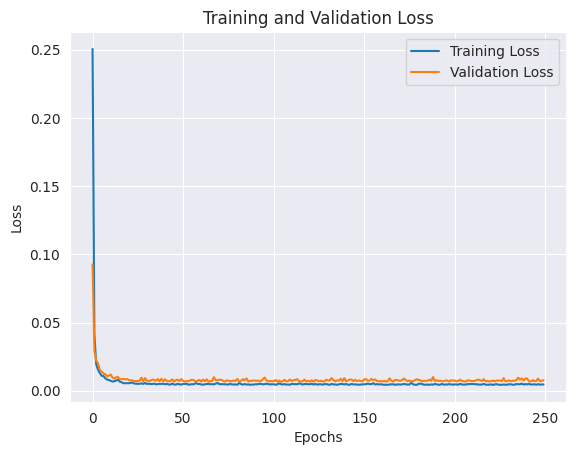

In [ ]:
history = compile_and_fit(AAPL_RET_8_ES_regressor,
                          X_train=AAPL_RET_MA_X_train,
                          Y_train=AAPL_RET_MA_Y_train,
                          X_val=AAPL_RET_MA_X_val,
                          Y_val=AAPL_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=16)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
AAPL_RET_8_ES_predictions = AAPL_RET_8_ES_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_8_ES, AAPL_smape_8_ES = AAPL_RET_8_ES_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 10ms/step - loss: 0.0038 - smape: 10.7140


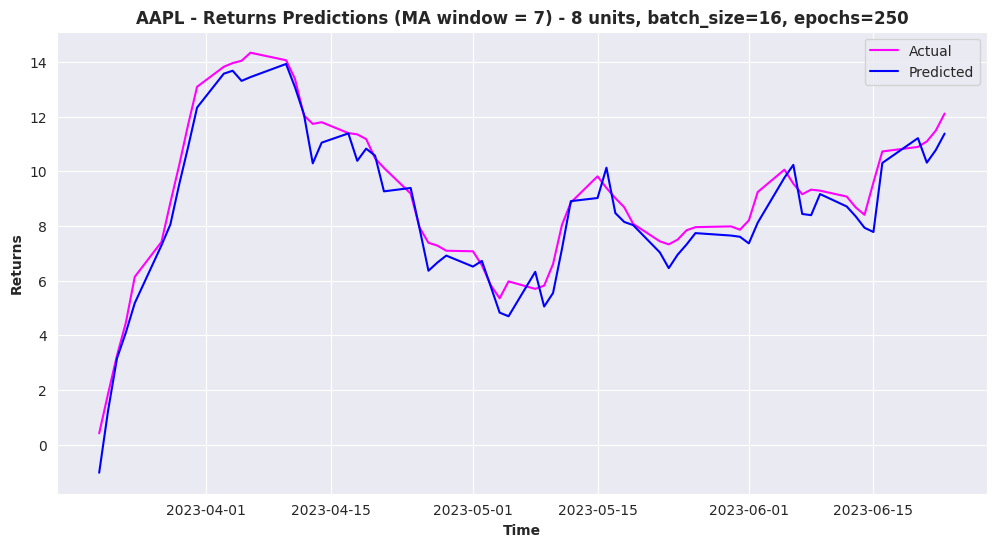

In [ ]:
# Inverse transform AAPL Returns
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_8_ES_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 8 units, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 8 units, `epochs`=250, `batch_size`=16**


In [ ]:
batch_size = 16

############### AMZN - RET_MA ###############
AMZN_RET_8_ES_regressor = Sequential()

AMZN_RET_8_ES_regressor.add(SimpleRNN(units=8,
                            batch_input_shape=(batch_size, 7, 1)))

AMZN_RET_8_ES_regressor.add(Dense(units=1))
#############################################

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (16, 8)                   80        
                                                                 
 dense_11 (Dense)            (16, 1)                   9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
32/32 [==============================] - 1s 14ms/step - loss: 0.1190 - smape: 49.9642 - val_loss: 0.0348 - val_smape: 34.0886
Epoch 2/250
32/32 [==============================] - 0s 4ms/step - loss: 0.0218 - smape: 25.9203 - val_loss: 0.0190 - val_smape: 23.8014
Epoch 3/250
32/32 [==============================] - 0s 5ms/step - loss: 0.0127 - smape: 22.3239 - val_loss: 0.0091 - val_smape: 20.8369
Epoch 4/250
32/32 [======================

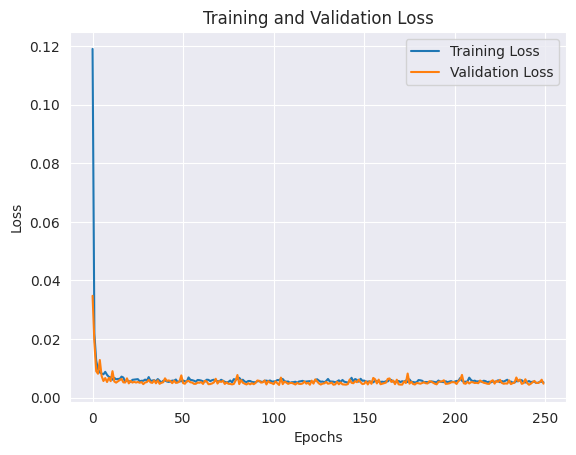

In [ ]:
history = compile_and_fit(AMZN_RET_8_ES_regressor,
                          X_train=AMZN_RET_MA_X_train,
                          Y_train=AMZN_RET_MA_Y_train,
                          X_val=AMZN_RET_MA_X_val,
                          Y_val=AMZN_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=16)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AMZN_RET_8_ES_predictions = AMZN_RET_8_ES_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_8_ES, AMZN_smape_8_ES = AMZN_RET_8_ES_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 6ms/step - loss: 0.0036 - smape: 9.6319


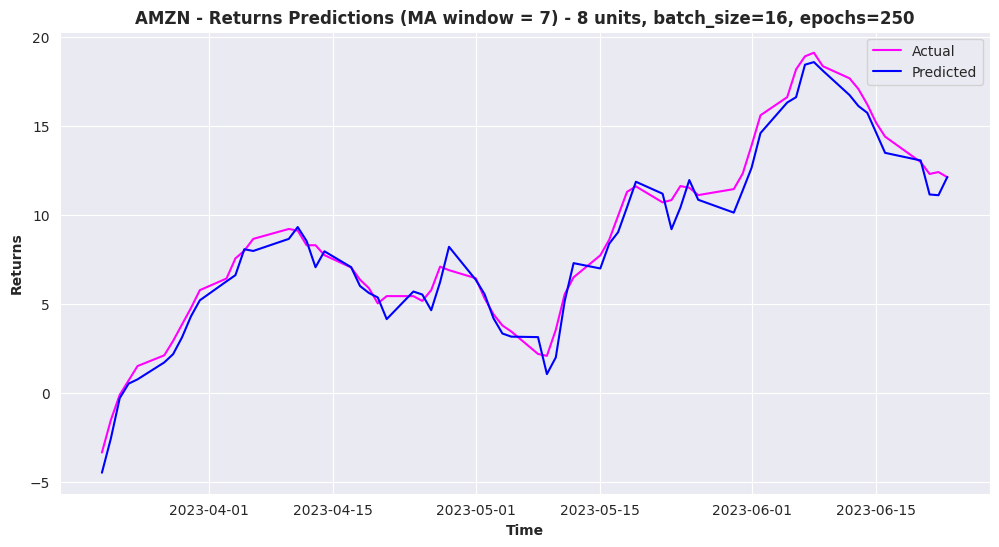

In [ ]:
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_8_ES_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 8 units, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AAPL - 16 units, `epochs`=250, `batch_size`=16**

In [ ]:
batch_size = 16

############### AAPL - RET_MA #############
AAPL_RET_16_ES_regressor = Sequential()

AAPL_RET_16_ES_regressor.add(SimpleRNN(units=16,
                            batch_input_shape=(batch_size, 7, 1)))

AAPL_RET_16_ES_regressor.add(Dense(units=1))
##########################################

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (16, 16)                  288       
                                                                 
 dense_12 (Dense)            (16, 1)                   17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
32/32 [==============================] - 1s 13ms/step - loss: 0.0411 - smape: 34.1639 - val_loss: 0.0226 - val_smape: 34.4665
Epoch 2/250
32/32 [==============================] - 0s 5ms/step - loss: 0.0145 - smape: 24.9578 - val_loss: 0.0143 - val_smape: 32.4834
Epoch 3/250
32/32 [==============================] - 0s 4ms/step - loss: 0.0073 - smape: 20.6798 - val_loss: 0.0124 - val_smape: 29.4512
Epoch 4/250
32/32 [====================

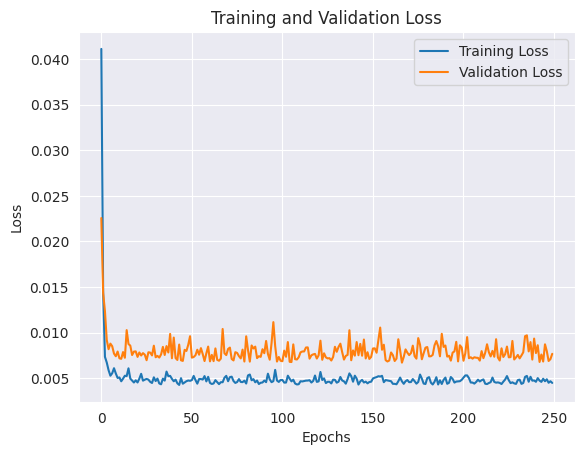

In [ ]:
history = compile_and_fit(AAPL_RET_16_ES_regressor,
                          X_train=AAPL_RET_MA_X_train,
                          Y_train=AAPL_RET_MA_Y_train,
                          X_val=AAPL_RET_MA_X_val,
                          Y_val=AAPL_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=16)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AAPL_RET_16_ES_predictions = AAPL_RET_16_ES_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_16_ES, AAPL_smape_16_ES = AAPL_RET_16_ES_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 5ms/step - loss: 0.0034 - smape: 9.9903


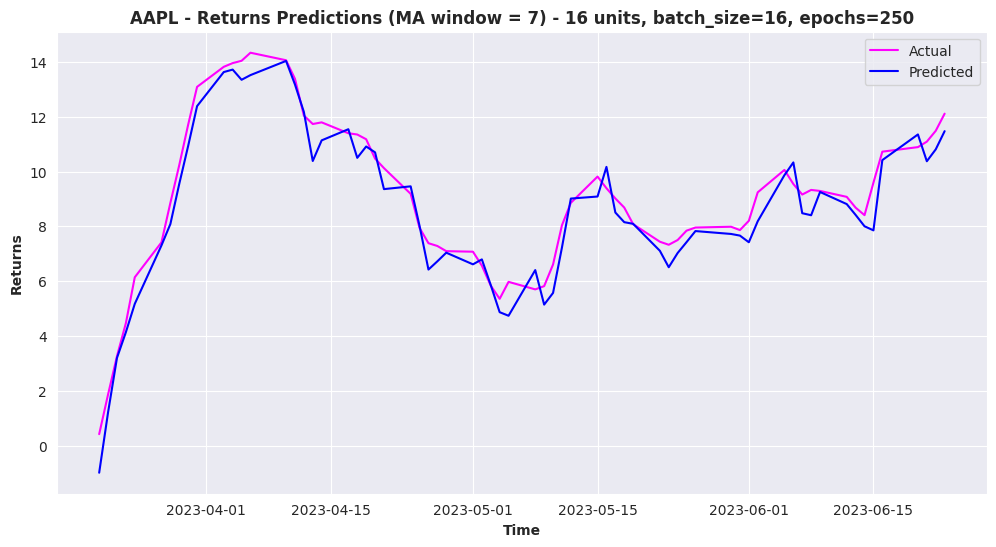

In [ ]:
# Inverse transform AAPL Returns
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_16_ES_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 16 units, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 16 units, `epochs`=250, `batch_size`=16**

In [ ]:
batch_size = 16

############### AMZN - RET_MA ###############
AMZN_RET_16_ES_regressor = Sequential()

AMZN_RET_16_ES_regressor.add(SimpleRNN(units=16,
                            batch_input_shape=(batch_size, 7, 1)))

AMZN_RET_16_ES_regressor.add(Dense(units=1))
#############################################

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_13 (SimpleRNN)   (16, 16)                  288       
                                                                 
 dense_13 (Dense)            (16, 1)                   17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
32/32 [==============================] - 1s 13ms/step - loss: 0.2597 - smape: 61.6415 - val_loss: 0.0203 - val_smape: 28.5420
Epoch 2/250
32/32 [==============================] - 0s 4ms/step - loss: 0.0271 - smape: 32.9502 - val_loss: 0.0138 - val_smape: 23.7684
Epoch 3/250
32/32 [==============================] - 0s 5ms/step - loss: 0.0177 - smape: 29.4335 - val_loss: 0.0113 - val_smape: 23.6257
Epoch 4/250
32/32 [====================

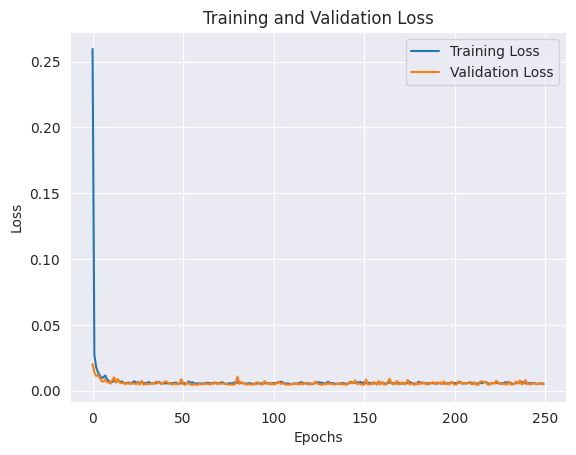

In [ ]:
history = compile_and_fit(AMZN_RET_16_ES_regressor,
                          X_train=AMZN_RET_MA_X_train,
                          Y_train=AMZN_RET_MA_Y_train,
                          X_val=AMZN_RET_MA_X_val,
                          Y_val=AMZN_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=16)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AMZN_RET_16_ES_predictions = AMZN_RET_16_ES_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_16_ES, AMZN_smape_16_ES = AMZN_RET_16_ES_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 7ms/step - loss: 0.0037 - smape: 9.2830


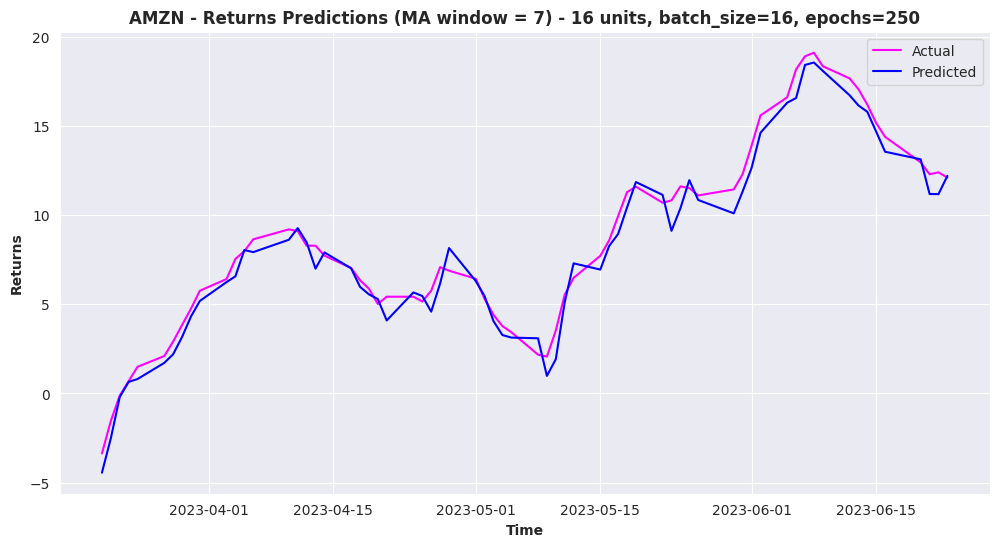

In [ ]:
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_16_ES_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 16 units, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AAPL - 32 units, `epochs`=250, `batch_size`=16**

In [ ]:
batch_size = 16

############### AAPL - RET_MA ###############
AAPL_RET_32_ES_regressor = Sequential()

AAPL_RET_32_ES_regressor.add(SimpleRNN(units=32,
                            batch_input_shape=(batch_size, 7, 1)))

AAPL_RET_32_ES_regressor.add(Dense(units=1))
#############################################

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_14 (SimpleRNN)   (16, 32)                  1088      
                                                                 
 dense_14 (Dense)            (16, 1)                   33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
32/32 [==============================] - 2s 19ms/step - loss: 0.1508 - smape: 51.8173 - val_loss: 0.0375 - val_smape: 42.7659
Epoch 2/250
32/32 [==============================] - 0s 6ms/step - loss: 0.0219 - smape: 31.9110 - val_loss: 0.0209 - val_smape: 37.8032
Epoch 3/250
32/32 [==============================] - 0s 5ms/step - loss: 0.0127 - smape: 26.6036 - val_loss: 0.0346 - val_smape: 38.6213
Epoch 4/250
32/32 [================

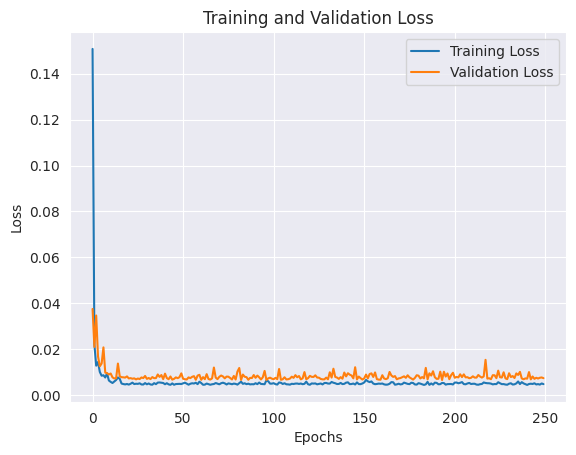

In [ ]:
history = compile_and_fit(AAPL_RET_32_ES_regressor,
                          X_train=AAPL_RET_MA_X_train,
                          Y_train=AAPL_RET_MA_Y_train,
                          X_val=AAPL_RET_MA_X_val,
                          Y_val=AAPL_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=16)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
AAPL_RET_32_ES_predictions = AAPL_RET_32_ES_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_32_ES, AAPL_smape_32_ES = AAPL_RET_32_ES_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 5ms/step - loss: 0.0024 - smape: 7.3042


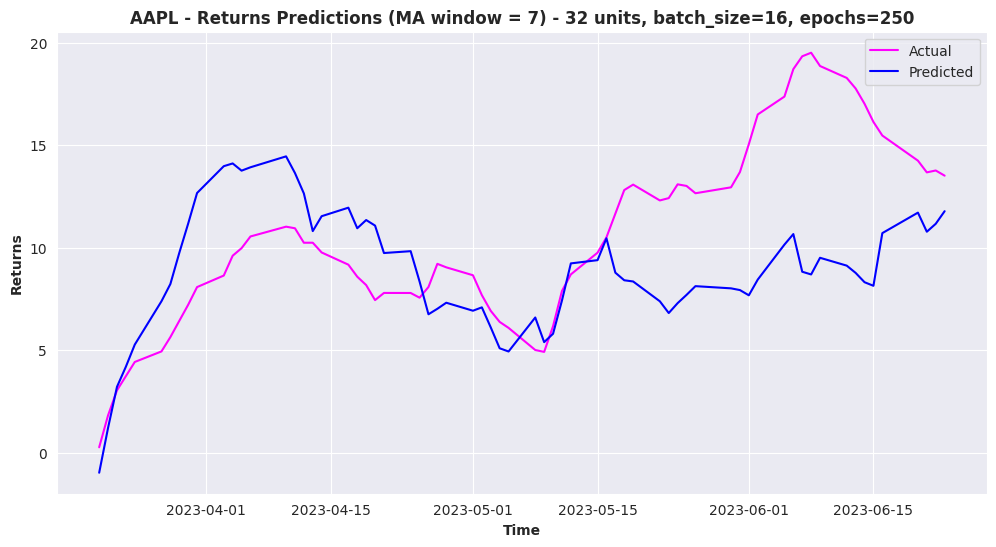

In [ ]:
# Inverse transform AAPL Returns
AAPL_test = (AMZN_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_32_ES_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 32 units, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 32 units, `epochs`=250, `batch_size`=16**

In [ ]:
batch_size = 16

############### AMZN - RET_MA ###############
AMZN_RET_32_ES_regressor = Sequential()

AMZN_RET_32_ES_regressor.add(SimpleRNN(units=32,
                            batch_input_shape=(batch_size, 7, 1)))

AMZN_RET_32_ES_regressor.add(Dense(units=1))
#############################################

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_15 (SimpleRNN)   (16, 32)                  1088      
                                                                 
 dense_15 (Dense)            (16, 1)                   33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
32/32 [==============================] - 1s 16ms/step - loss: 0.0848 - smape: 45.1729 - val_loss: 0.0134 - val_smape: 25.8337
Epoch 2/250
32/32 [==============================] - 0s 5ms/step - loss: 0.0108 - smape: 25.7038 - val_loss: 0.0068 - val_smape: 20.1112
Epoch 3/250
32/32 [==============================] - 0s 5ms/step - loss: 0.0079 - smape: 21.6936 - val_loss: 0.0065 - val_smape: 18.2991
Epoch 4/250
32/32 [================

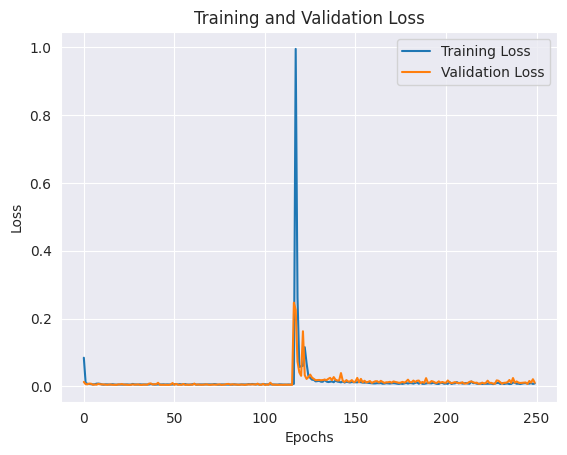

In [ ]:
history = compile_and_fit(AMZN_RET_32_ES_regressor,
                          X_train=AMZN_RET_MA_X_train,
                          Y_train=AMZN_RET_MA_Y_train,
                          X_val=AMZN_RET_MA_X_val,
                          Y_val=AMZN_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=16)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AMZN_RET_32_ES_predictions = AMZN_RET_32_ES_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_32_ES, AMZN_smape_32_ES = AMZN_RET_32_ES_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 6ms/step - loss: 0.0104 - smape: 15.6342


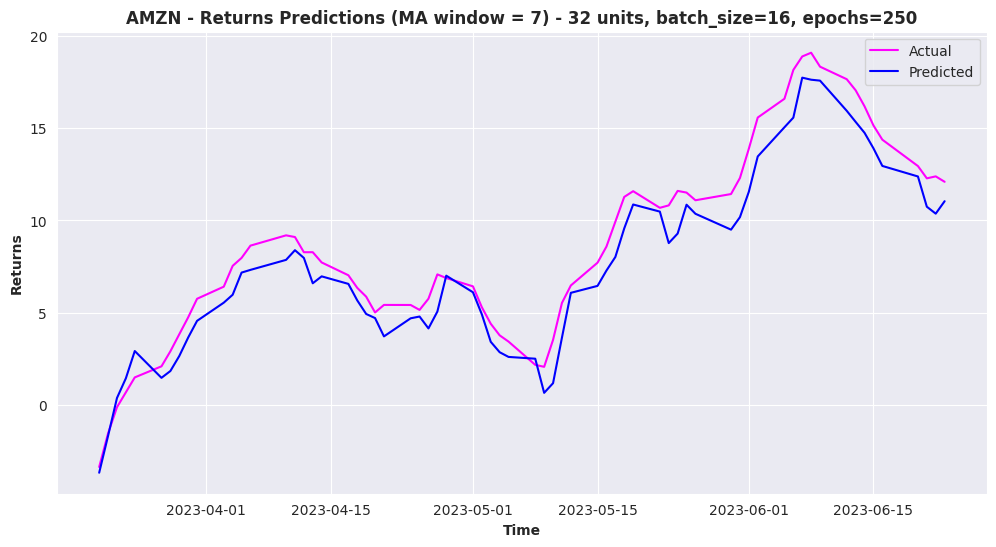

In [ ]:
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_32_ES_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 32 units, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

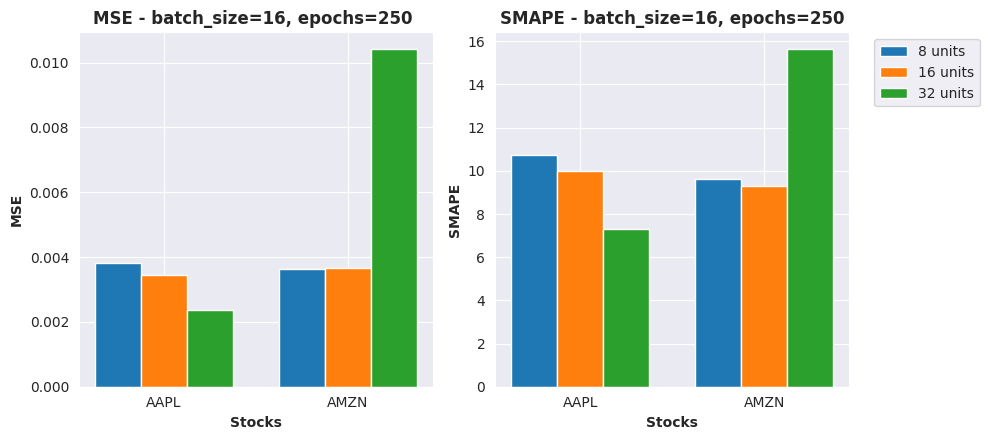

In [ ]:
labels = ['AAPL', 'AMZN']
x = np.arange(len(labels))

loss_values = np.array([[AAPL_loss_8_ES, AAPL_loss_16_ES, AAPL_loss_32_ES],     [AMZN_loss_8_ES, AMZN_loss_16_ES, AMZN_loss_32_ES]])
smape_values  = np.array([[AAPL_smape_8_ES, AAPL_smape_16_ES, AAPL_smape_32_ES], [AMZN_smape_8_ES, AMZN_smape_16_ES, AMZN_smape_32_ES]])

fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))

# Plotting the loss bar chart
axs[0].bar(x, loss_values[:, 0], width=0.25, align='center', label='8 units')
axs[0].bar(x + 0.25, loss_values[:, 1], width=0.25, align='center', label='16 units')
axs[0].bar(x + 0.5, loss_values[:, 2], width=0.25, align='center', label='32 units')
axs[0].set_xticks(x + 0.25, labels)
axs[0].set_xlabel('Stocks', fontweight='bold')
axs[0].set_ylabel('MSE', fontweight='bold')
axs[0].set_title('MSE - batch_size=16, epochs=250 ', fontweight='bold')

# Plotting the smape bar chart
axs[1].bar(x, smape_values[:, 0], width=0.25, align='center', label='8 units')
axs[1].bar(x + 0.25, smape_values[:, 1], width=0.25, align='center', label='16 units')
axs[1].bar(x + 0.5, smape_values[:, 2], width=0.25, align='center', label='32 units')
axs[1].set_xticks(x + 0.25, labels)
axs[1].set_xlabel('Stocks', fontweight='bold')
axs[1].set_ylabel('SMAPE', fontweight='bold')
axs[1].set_title('SMAPE - batch_size=16, epochs=250', fontweight='bold')

# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## **Adding stacked LSTM layers**

### **AAPL - 2 layers, 64 units per layer, `epochs`=250, `batch_size`=32**

In [ ]:
batch_size = 32

############### AAPL - RET_MA ###############
AAPL_RET_64_2L_regressor = Sequential()

AAPL_RET_64_2L_regressor.add(SimpleRNN(units=64,
                            batch_input_shape=(batch_size, 7, 1),
                            return_sequences=True))

AAPL_RET_64_2L_regressor.add(SimpleRNN(units=64))

AAPL_RET_64_2L_regressor.add(Dense(units=1))
#############################################

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_16 (SimpleRNN)   (32, 7, 64)               4224      
                                                                 
 simple_rnn_17 (SimpleRNN)   (32, 64)                  8256      
                                                                 
 dense_16 (Dense)            (32, 1)                   65        
                                                                 
Total params: 12,545
Trainable params: 12,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 3s 78ms/step - loss: 1.1238 - smape: 79.2589 - val_loss: 0.1401 - val_smape: 62.7918
Epoch 2/250
16/16 [==============================] - 0s 10ms/step - loss: 0.0495 - smape: 40.0464 - val_loss: 0.0272 - val_smape: 46.0084
Epoch 3/250
16/16 [==================

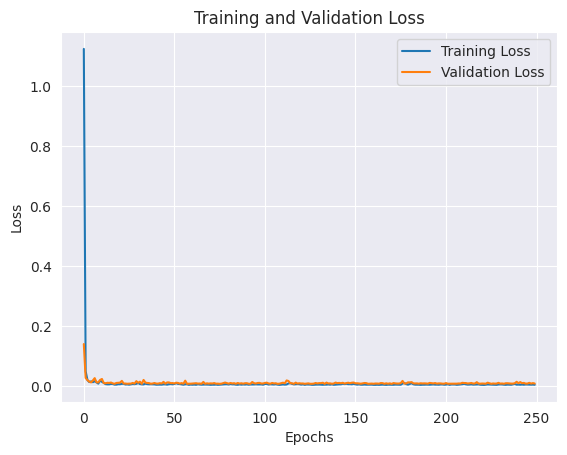

In [ ]:
history = compile_and_fit(AAPL_RET_64_2L_regressor,
                          X_train=AAPL_RET_MA_X_train,
                          Y_train=AAPL_RET_MA_Y_train,
                          X_val=AAPL_RET_MA_X_val,
                          Y_val=AAPL_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AAPL_RET_64_2L_predictions = AAPL_RET_64_2L_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_64_2L, AAPL_smape_64_2L = AAPL_RET_64_2L_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 8ms/step - loss: 0.0021 - smape: 6.0034


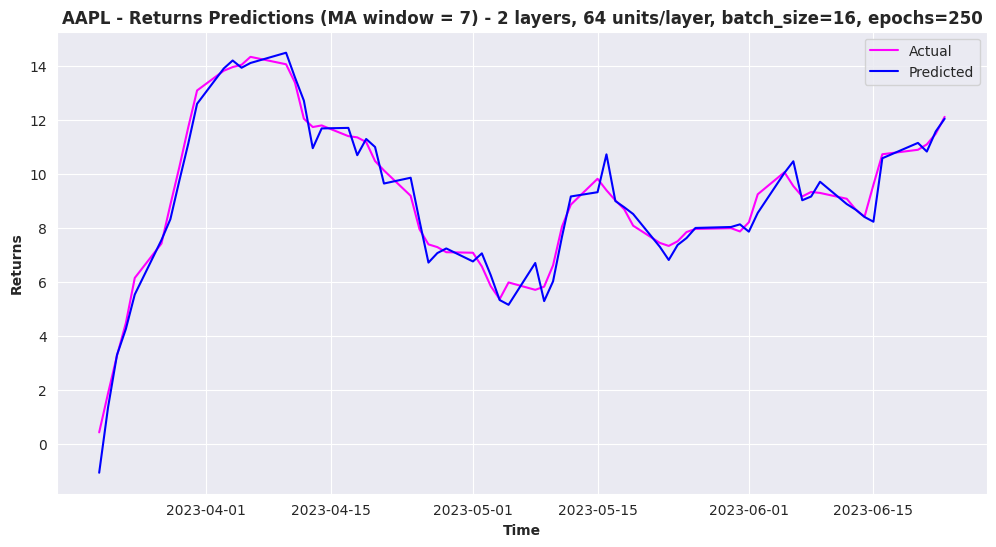

In [ ]:
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_64_2L_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 2 layers, 64 units/layer, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 2 layers, 64 units per layer, `epochs`=250, `batch_size`=32**

In [ ]:
batch_size = 32

############### AMZN - RET_MA ###############
AMZN_RET_64_2L_regressor = Sequential()

AMZN_RET_64_2L_regressor.add(SimpleRNN(units=64,
                            batch_input_shape=(batch_size, 7, 1),
                            return_sequences=True))

AMZN_RET_64_2L_regressor.add(SimpleRNN(units=64))

AMZN_RET_64_2L_regressor.add(Dense(units=1))
#############################################

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_18 (SimpleRNN)   (32, 7, 64)               4224      
                                                                 
 simple_rnn_19 (SimpleRNN)   (32, 64)                  8256      
                                                                 
 dense_17 (Dense)            (32, 1)                   65        
                                                                 
Total params: 12,545
Trainable params: 12,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 2s 33ms/step - loss: 0.7639 - smape: 91.2002 - val_loss: 0.2139 - val_smape: 81.1386
Epoch 2/250
16/16 [==============================] - 0s 10ms/step - loss: 0.0753 - smape: 50.2504 - val_loss: 0.0280 - val_smape: 37.6876
Epoch 3/250
16/16 [==================

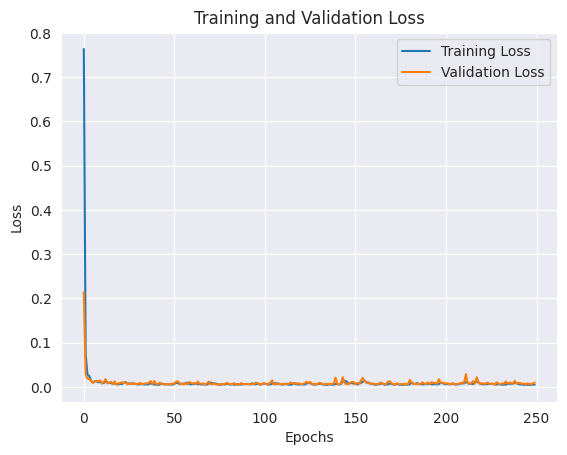

In [ ]:
history = compile_and_fit(AMZN_RET_64_2L_regressor,
                          X_train=AMZN_RET_MA_X_train,
                          Y_train=AMZN_RET_MA_Y_train,
                          X_val=AMZN_RET_MA_X_val,
                          Y_val=AMZN_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AMZN_RET_64_2L_predictions = AMZN_RET_64_2L_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_64_2L, AMZN_smape_64_2L = AMZN_RET_64_2L_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 5ms/step - loss: 0.0122 - smape: 16.6233


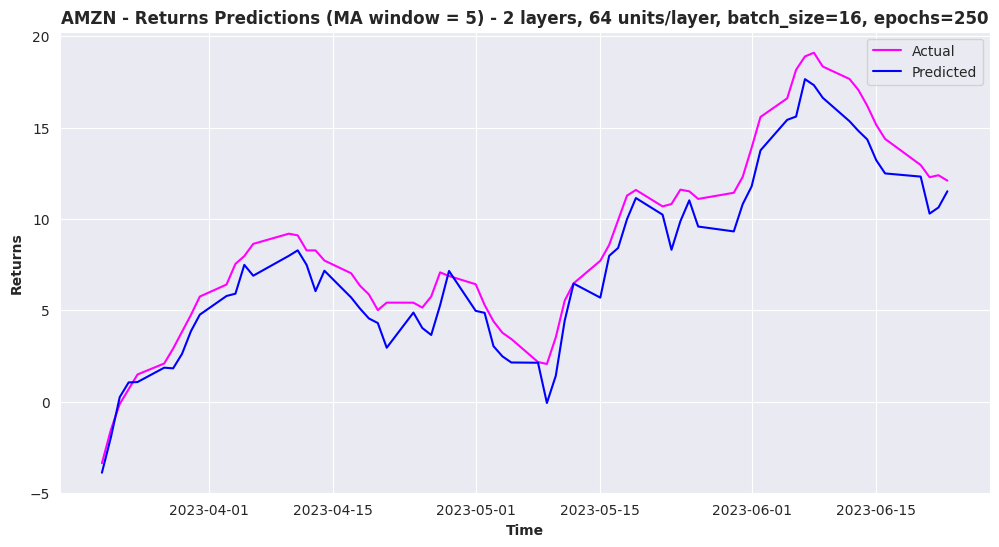

In [ ]:
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_64_2L_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = 5) - 2 layers, 64 units/layer, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AAPL - 2 layers, 128 units per layer, `epochs`=250, `batch_size`=32**

In [ ]:
batch_size = 32


AAPL_RET_128_2L_regressor = Sequential()

AAPL_RET_128_2L_regressor.add(SimpleRNN(units=128,
                            batch_input_shape=(batch_size, 7, 1),
                            return_sequences=True))

AAPL_RET_128_2L_regressor.add(SimpleRNN(units=128))

AAPL_RET_128_2L_regressor.add(Dense(units=1))

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_20 (SimpleRNN)   (32, 7, 128)              16640     
                                                                 
 simple_rnn_21 (SimpleRNN)   (32, 128)                 32896     
                                                                 
 dense_18 (Dense)            (32, 1)                   129       
                                                                 
Total params: 49,665
Trainable params: 49,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 5s 169ms/step - loss: 3.6424 - smape: 116.5835 - val_loss: 0.8552 - val_smape: 110.9138
Epoch 2/250
16/16 [==============================] - 1s 31ms/step - loss: 0.7381 - smape: 114.8130 - val_loss: 0.7697 - val_smape: 114.0399
Epoch 3/250
16/16 [=============

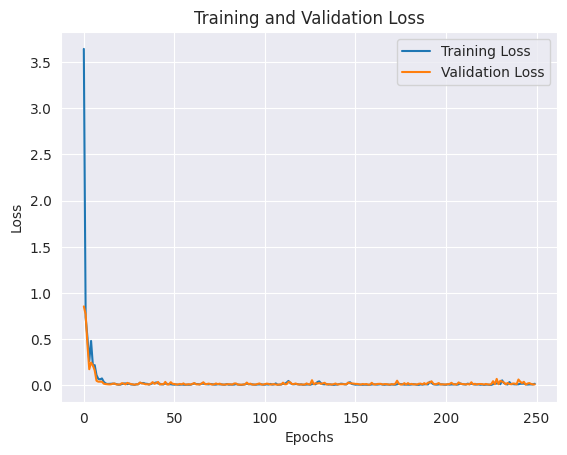

In [ ]:
history = compile_and_fit(AAPL_RET_128_2L_regressor,
                          X_train=AAPL_RET_MA_X_train,
                          Y_train=AAPL_RET_MA_Y_train,
                          X_val=AAPL_RET_MA_X_val,
                          Y_val=AAPL_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AAPL_RET_128_2L_predictions = AAPL_RET_128_2L_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_128_2L, AAPL_smape_128_2L = AAPL_RET_128_2L_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 6ms/step - loss: 0.0037 - smape: 8.8073


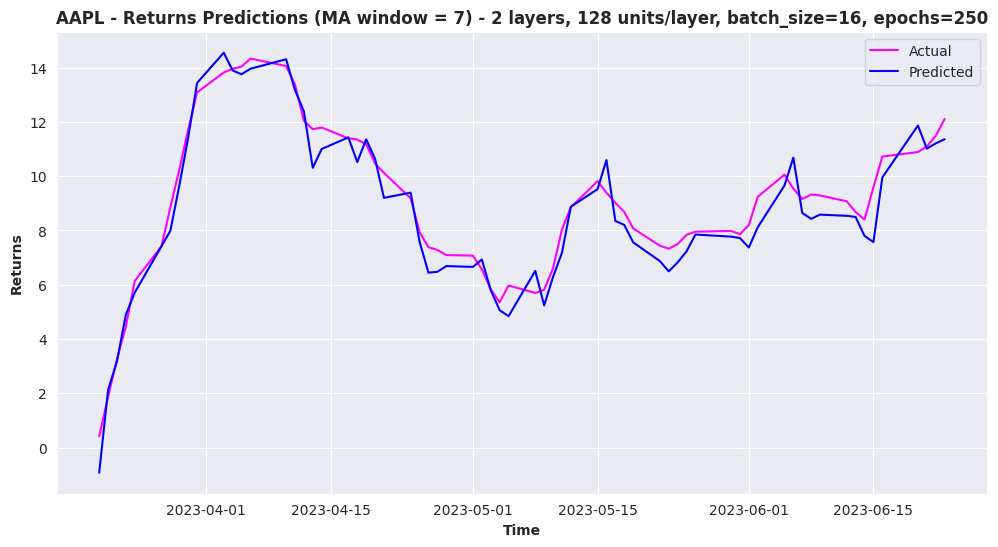

In [ ]:
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_128_2L_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 2 layers, 128 units/layer, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 2 layers, 128 units per layer, `epochs`=250, `batch_size`=32**

In [ ]:
batch_size = 32

############### AMZN - RET_MA ###############
AMZN_RET_128_2L_regressor = Sequential()

AMZN_RET_128_2L_regressor.add(SimpleRNN(units=128,
                            batch_input_shape=(batch_size, 7, 1),
                            return_sequences=True))

AMZN_RET_128_2L_regressor.add(SimpleRNN(units=128))

AMZN_RET_128_2L_regressor.add(Dense(units=1))
#############################################

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_22 (SimpleRNN)   (32, 7, 128)              16640     
                                                                 
 simple_rnn_23 (SimpleRNN)   (32, 128)                 32896     
                                                                 
 dense_19 (Dense)            (32, 1)                   129       
                                                                 
Total params: 49,665
Trainable params: 49,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 2s 37ms/step - loss: 6.7118 - smape: 145.0962 - val_loss: 0.4576 - val_smape: 93.3023
Epoch 2/250
16/16 [==============================] - 0s 11ms/step - loss: 0.8748 - smape: 122.2189 - val_loss: 0.4280 - val_smape: 91.1859
Epoch 3/250
16/16 [================

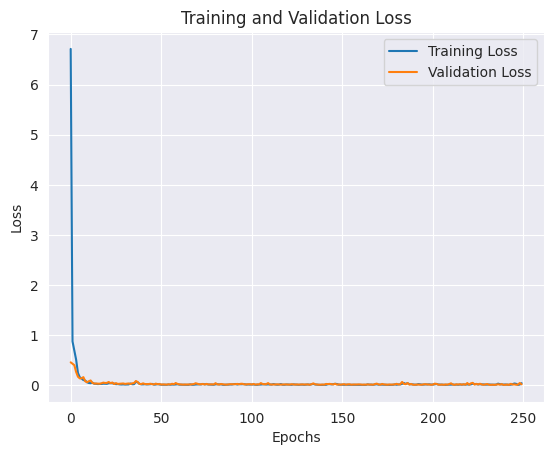

In [ ]:
history = compile_and_fit(AMZN_RET_128_2L_regressor,
                          X_train=AMZN_RET_MA_X_train,
                          Y_train=AMZN_RET_MA_Y_train,
                          X_val=AMZN_RET_MA_X_val,
                          Y_val=AMZN_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AMZN_RET_128_2L_predictions = AMZN_RET_128_2L_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_128_2L, AMZN_smape_128_2L = AMZN_RET_128_2L_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 7ms/step - loss: 0.0171 - smape: 24.9948


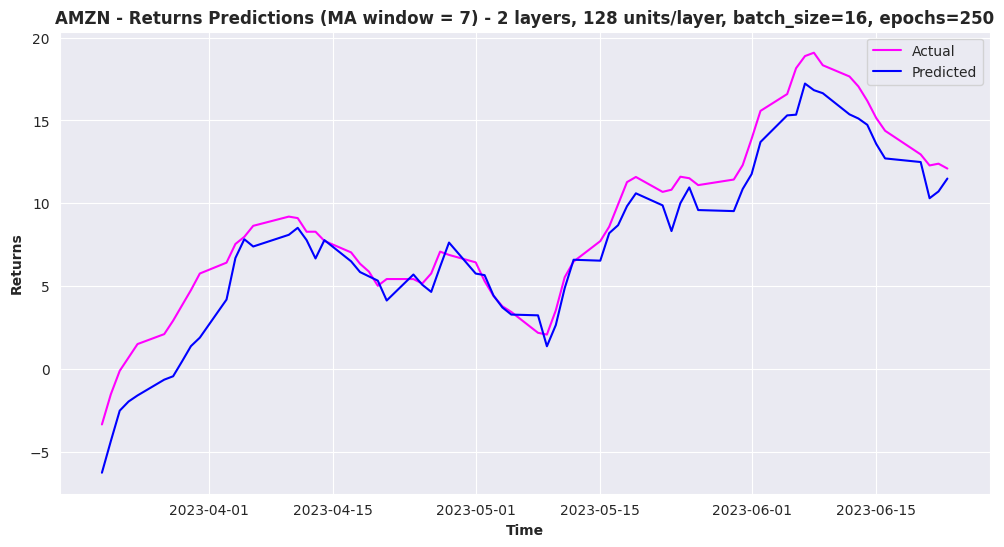

In [ ]:
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_128_2L_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 2 layers, 128 units/layer, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

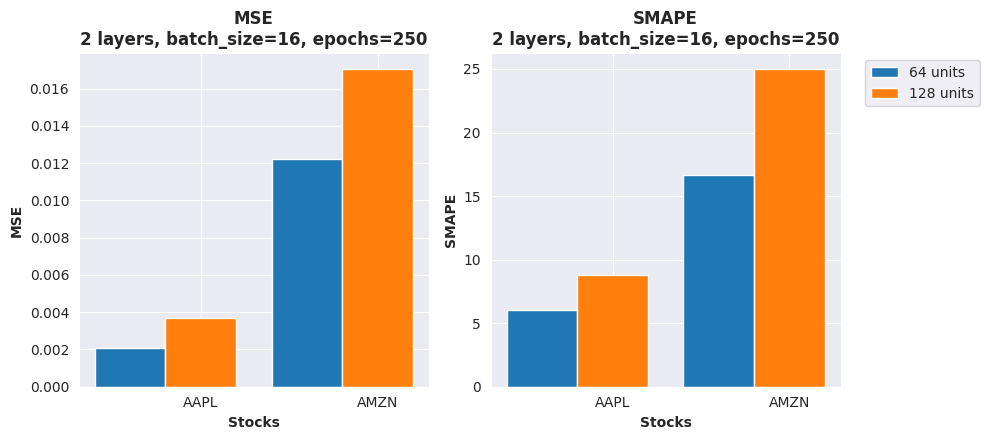

In [ ]:
labels = ['AAPL', 'AMZN']
x = np.arange(len(labels))

loss_values = np.array([[AAPL_loss_64_2L, AAPL_loss_128_2L],     [AMZN_loss_64_2L, AMZN_loss_128_2L]])
smape_values  = np.array([[AAPL_smape_64_2L, AAPL_smape_128_2L], [AMZN_smape_64_2L, AMZN_smape_128_2L]])

fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))

# Plotting the loss bar chart
axs[0].bar(x, loss_values[:, 0], width=0.4, align='center', label='64 units')
axs[0].bar(x + 0.4, loss_values[:, 1], width=0.4, align='center', label='128 units')
axs[0].set_xticks(x + 0.4, labels)
axs[0].set_xlabel('Stocks', fontweight='bold')
axs[0].set_ylabel('MSE', fontweight='bold')
axs[0].set_title('MSE\n2 layers, batch_size=16, epochs=250', fontweight='bold')

# Plotting the smape bar chart
axs[1].bar(x, smape_values[:, 0], width=0.4, align='center', label='64 units')
axs[1].bar(x + 0.4, smape_values[:, 1], width=0.4, align='center', label='128 units')
axs[1].set_xticks(x + 0.4, labels)
axs[1].set_xlabel('Stocks', fontweight='bold')
axs[1].set_ylabel('SMAPE', fontweight='bold')
axs[1].set_title('SMAPE\n2 layers, batch_size=16, epochs=250', fontweight='bold')

# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# **Adding dropout**

### **AAPL - 2 layers, 64 units per layer, `epochs`=250, `batch_size`=32, `dropout`=0.2**

In [ ]:
batch_size = 32

############### AMZN - RET_MA ###############
AAPL_RET_64_2L_D_regressor = Sequential()

AAPL_RET_64_2L_D_regressor.add(SimpleRNN(units=64,
                                  dropout=0.2,
                                  batch_input_shape=(batch_size, 7, 1),
                                  return_sequences=True))

AAPL_RET_64_2L_D_regressor.add(SimpleRNN(units=64,
                                  dropout=0.2))

AAPL_RET_64_2L_D_regressor.add(Dense(units=1))
#############################################

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_24 (SimpleRNN)   (32, 7, 64)               4224      
                                                                 
 simple_rnn_25 (SimpleRNN)   (32, 64)                  8256      
                                                                 
 dense_20 (Dense)            (32, 1)                   65        
                                                                 
Total params: 12,545
Trainable params: 12,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 2s 37ms/step - loss: 0.8338 - smape: 93.3596 - val_loss: 0.2572 - val_smape: 63.9318
Epoch 2/250
16/16 [==============================] - 0s 11ms/step - loss: 0.2501 - smape: 67.1006 - val_loss: 0.1632 - val_smape: 62.4165
Epoch 3/250
16/16 [==================

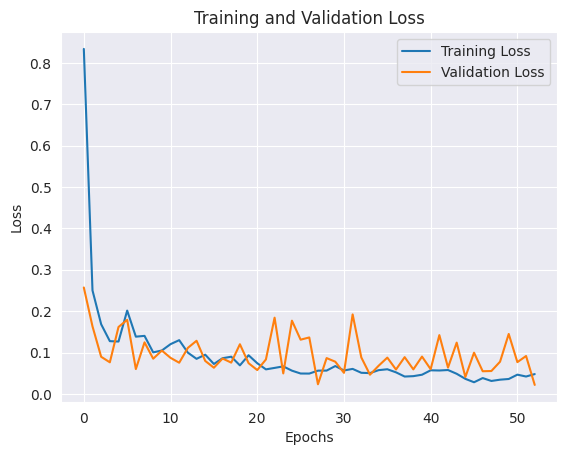

In [ ]:
history = compile_and_fit(AAPL_RET_64_2L_D_regressor,
                          X_train=AAPL_RET_MA_X_train,
                          Y_train=AAPL_RET_MA_Y_train,
                          X_val=AAPL_RET_MA_X_val,
                          Y_val=AAPL_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32,
                          _early_stopping=True,
                          _patience=25)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AAPL_RET_64_2L_D_predictions = AAPL_RET_64_2L_D_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_64_2L_D, AAPL_smape_64_2L_D = AAPL_RET_64_2L_D_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 6ms/step - loss: 0.0055 - smape: 13.2849


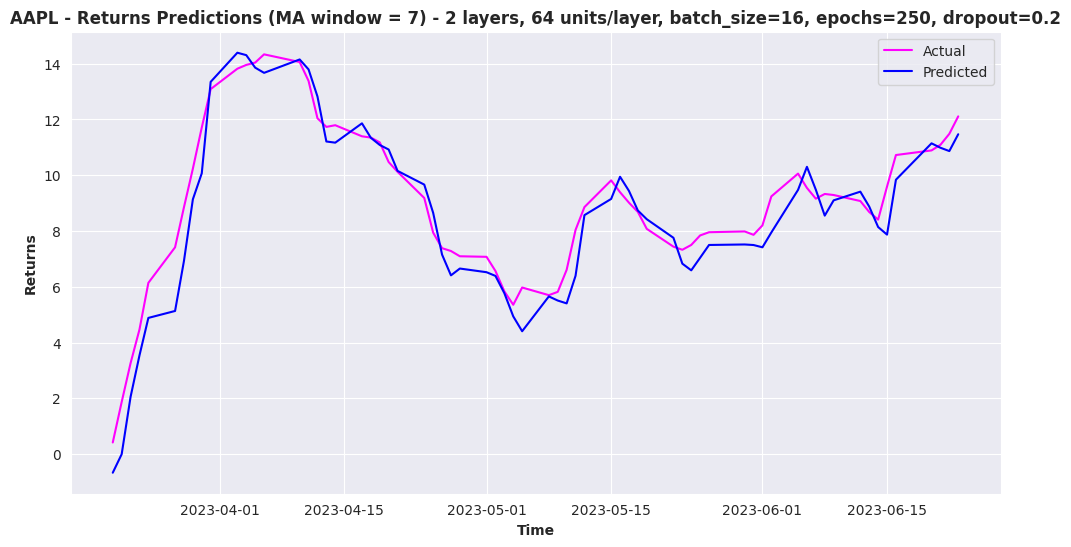

In [ ]:
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_64_2L_D_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 2 layers, 64 units/layer, batch_size=16, epochs=250, dropout=0.2', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 2 layers, 64 units per layer, `epochs`=250, `batch_size`=32, `dropout`=0.2**

In [ ]:
batch_size = 32

############### AMZN - LOGRET_MA ###############
AMZN_RET_64_2L_D_regressor = Sequential()

AMZN_RET_64_2L_D_regressor.add(SimpleRNN(units=64,
                                  dropout=0.2,
                                  batch_input_shape=(batch_size, 7, 1),
                                  return_sequences=True))

AMZN_RET_64_2L_D_regressor.add(SimpleRNN(units=64,
                                  dropout=0.2))

AMZN_RET_64_2L_D_regressor.add(Dense(units=1))
################################################

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_26 (SimpleRNN)   (32, 7, 64)               4224      
                                                                 
 simple_rnn_27 (SimpleRNN)   (32, 64)                  8256      
                                                                 
 dense_21 (Dense)            (32, 1)                   65        
                                                                 
Total params: 12,545
Trainable params: 12,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 2s 34ms/step - loss: 1.4356 - smape: 97.6350 - val_loss: 0.0762 - val_smape: 55.9460
Epoch 2/250
16/16 [==============================] - 0s 11ms/step - loss: 0.2106 - smape: 68.0621 - val_loss: 0.0390 - val_smape: 43.8298
Epoch 3/250
16/16 [==================

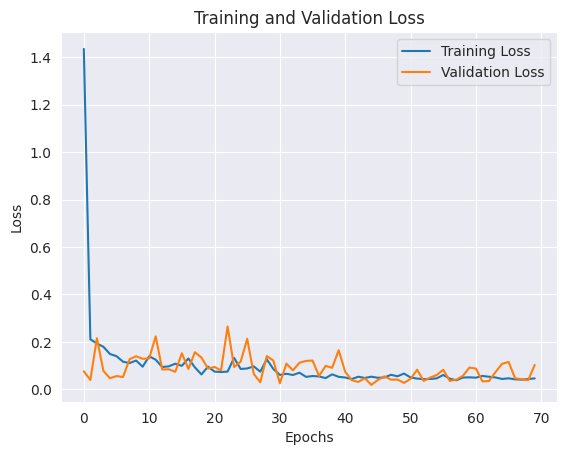

In [ ]:
history = compile_and_fit(AMZN_RET_64_2L_D_regressor,
                          X_train=AMZN_RET_MA_X_train,
                          Y_train=AMZN_RET_MA_Y_train,
                          X_val=AMZN_RET_MA_X_val,
                          Y_val=AMZN_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32,
                          _early_stopping=True,
                          _patience=25)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AMZN_RET_64_2L_D_predictions = AMZN_RET_64_2L_D_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_64_2L_D, AMZN_smape_64_2L_D = AMZN_RET_64_2L_D_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 5ms/step - loss: 0.0603 - smape: 43.1265


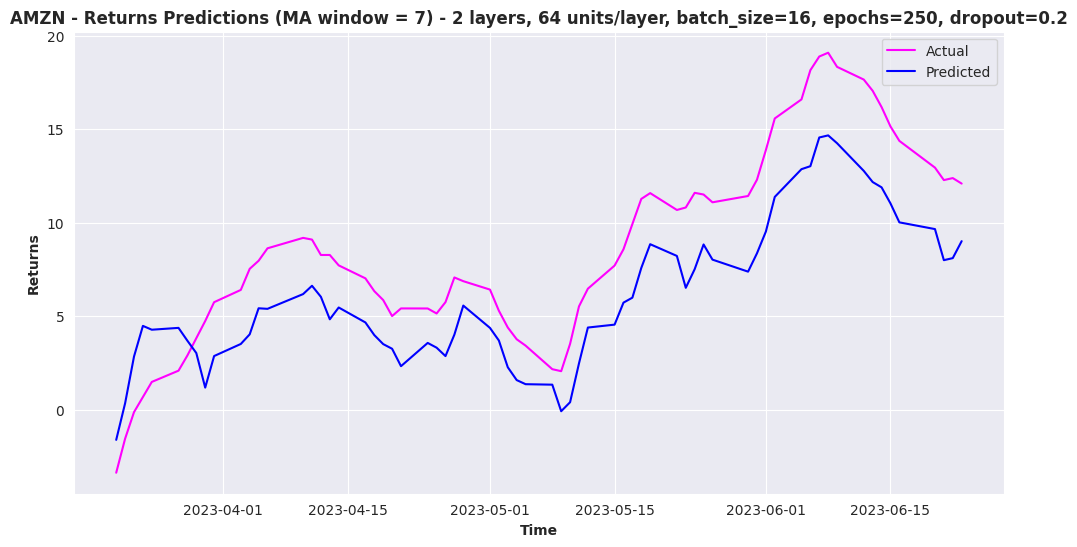

In [ ]:
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_64_2L_D_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 2 layers, 64 units/layer, batch_size=16, epochs=250, dropout=0.2', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AAPL - 2 layers, 128 units per layer, `epochs`=250, `batch_size`=32, `dropout`=0.2**

In [ ]:
batch_size = 32

############### AMZN - RET_MA ###############
AAPL_RET_128_2L_D_regressor = Sequential()

AAPL_RET_128_2L_D_regressor.add(SimpleRNN(units=128,
                                  dropout=0.2,
                                  batch_input_shape=(batch_size, 7, 1),
                                  return_sequences=True))

AAPL_RET_128_2L_D_regressor.add(SimpleRNN(units=128,
                                  dropout=0.2))

AAPL_RET_128_2L_D_regressor.add(Dense(units=1))
#############################################

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_28 (SimpleRNN)   (32, 7, 128)              16640     
                                                                 
 simple_rnn_29 (SimpleRNN)   (32, 128)                 32896     
                                                                 
 dense_22 (Dense)            (32, 1)                   129       
                                                                 
Total params: 49,665
Trainable params: 49,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 2s 37ms/step - loss: 2.7757 - smape: 107.2278 - val_loss: 0.7934 - val_smape: 117.9069
Epoch 2/250
16/16 [==============================] - 0s 16ms/step - loss: 0.4398 - smape: 86.4108 - val_loss: 0.2294 - val_smape: 70.5910
Epoch 3/250
16/16 [================

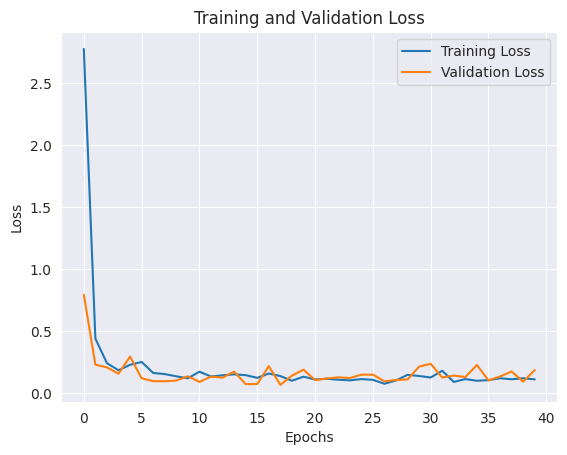

In [ ]:
history = compile_and_fit(AAPL_RET_128_2L_D_regressor,
                          X_train=AAPL_RET_MA_X_train,
                          Y_train=AAPL_RET_MA_Y_train,
                          X_val=AAPL_RET_MA_X_val,
                          Y_val=AAPL_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32,
                          _early_stopping=True,
                          _patience=25)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AAPL_RET_128_2L_D_predictions = AAPL_RET_128_2L_D_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_128_2L_D, AAPL_smape_128_2L_D = AAPL_RET_128_2L_D_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 6ms/step - loss: 0.0809 - smape: 56.3635


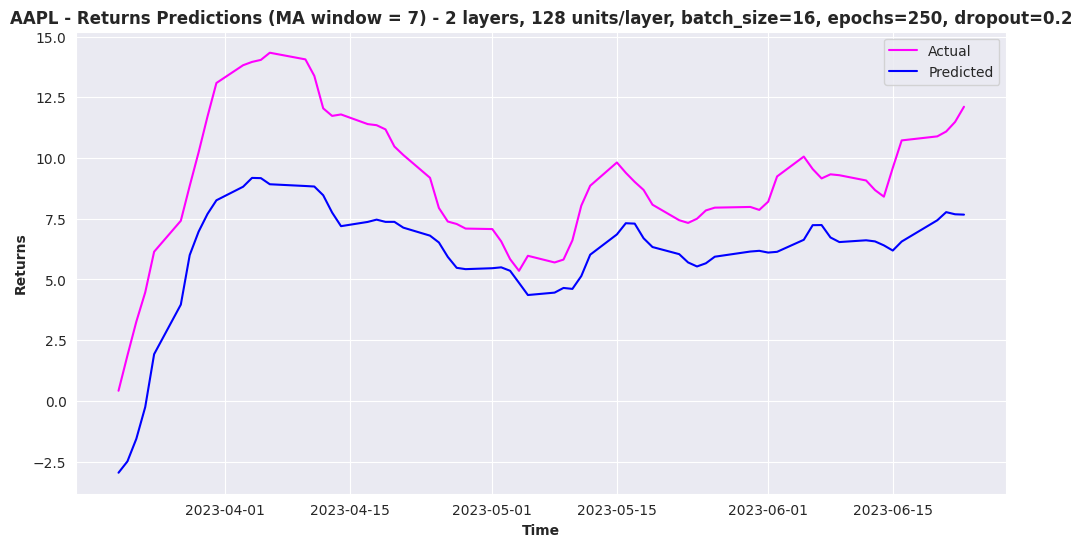

In [ ]:
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_128_2L_D_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 2 layers, 128 units/layer, batch_size=16, epochs=250, dropout=0.2', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 2 layers, 128 units per layer, `epochs`=250, `batch_size`=32, `dropout`=0.2**

In [ ]:
batch_size = 32

############### AMZN - LOGRET_MA ###############
AMZN_RET_128_2L_D_regressor = Sequential()

AMZN_RET_128_2L_D_regressor.add(SimpleRNN(units=128,
                                  dropout=0.2,
                                  batch_input_shape=(batch_size, 7, 1),
                                  return_sequences=True))

AMZN_RET_128_2L_D_regressor.add(SimpleRNN(units=128,
                                  dropout=0.2))

AMZN_RET_128_2L_D_regressor.add(Dense(units=1))
################################################

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_30 (SimpleRNN)   (32, 7, 128)              16640     
                                                                 
 simple_rnn_31 (SimpleRNN)   (32, 128)                 32896     
                                                                 
 dense_23 (Dense)            (32, 1)                   129       
                                                                 
Total params: 49,665
Trainable params: 49,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 3s 79ms/step - loss: 3.1640 - smape: 124.4061 - val_loss: 0.6748 - val_smape: 117.7167
Epoch 2/250
16/16 [==============================] - 0s 19ms/step - loss: 0.8735 - smape: 108.8375 - val_loss: 0.4531 - val_smape: 93.6471
Epoch 3/250
16/16 [===============

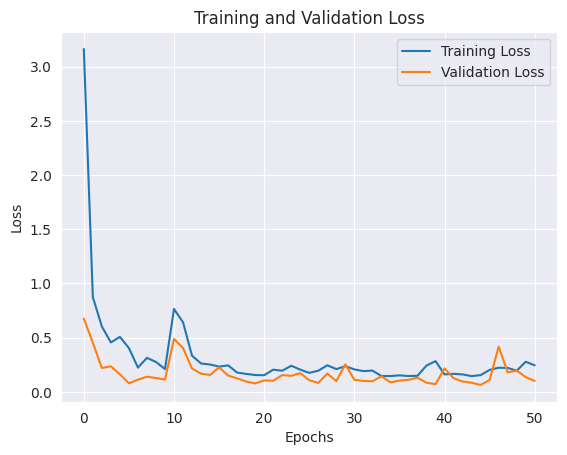

In [ ]:
history = compile_and_fit(AMZN_RET_128_2L_D_regressor,
                          X_train=AMZN_RET_MA_X_train,
                          Y_train=AMZN_RET_MA_Y_train,
                          X_val=AMZN_RET_MA_X_val,
                          Y_val=AMZN_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32,
                          _early_stopping=True,
                          _patience=25)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AMZN_RET_128_2L_D_predictions = AMZN_RET_128_2L_D_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_128_2L_D, AMZN_smape_128_2L_D = AMZN_RET_128_2L_D_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 5ms/step - loss: 0.0496 - smape: 33.5205


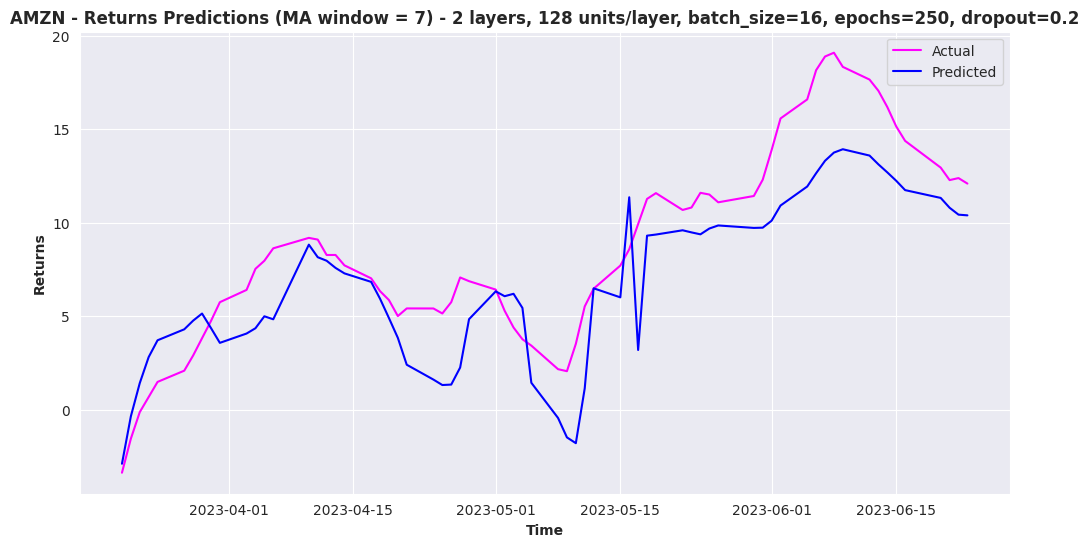

In [ ]:
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_128_2L_D_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 2 layers, 128 units/layer, batch_size=16, epochs=250, dropout=0.2', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

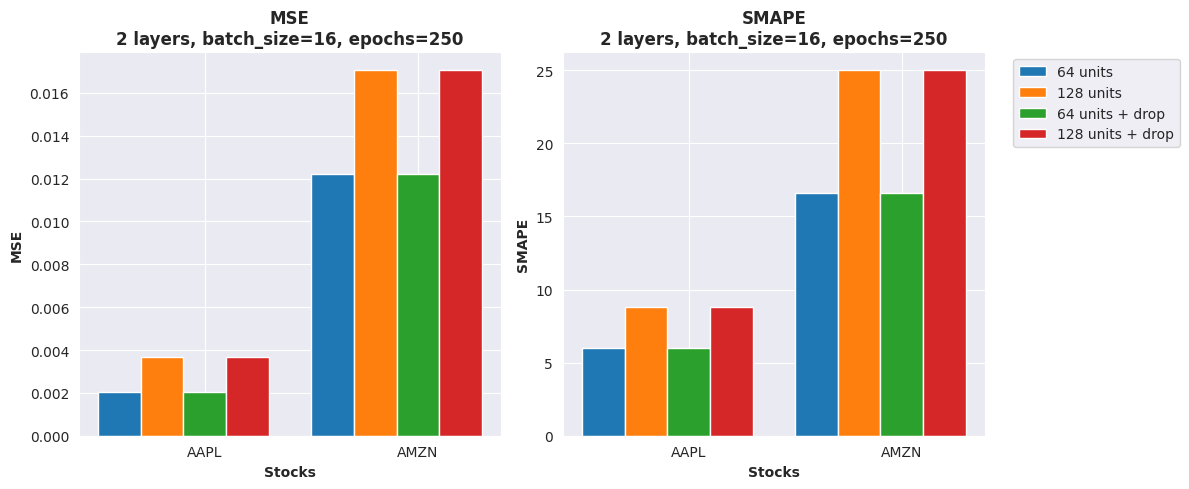

In [ ]:
labels = ['AAPL', 'AMZN']
x = np.arange(len(labels))

loss_values = np.array([[AAPL_loss_64_2L, AAPL_loss_128_2L, AAPL_loss_64_2L_D, AAPL_loss_128_2L_D],       [AMZN_loss_64_2L, AMZN_loss_128_2L, AMZN_loss_64_2L_D, AMZN_loss_128_2L_D]])
smape_values  = np.array([[AAPL_smape_64_2L, AAPL_smape_128_2L, AAPL_smape_64_2L_D, AAPL_smape_128_2L_D], [AMZN_smape_64_2L, AMZN_smape_128_2L, AMZN_smape_64_2L_D, AMZN_smape_128_2L_D]])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the loss bar chart
axs[0].bar(x, loss_values[:, 0], width=0.2, align='center', label='64 units')
axs[0].bar(x + 0.2, loss_values[:, 1], width=0.2, align='center', label='128 units')
axs[0].bar(x + 0.4, loss_values[:, 0], width=0.2, align='center', label='64 units + drop')
axs[0].bar(x + 0.6, loss_values[:, 1], width=0.2, align='center', label='128 units + drop')
axs[0].set_xticks(x + 0.4, labels)
axs[0].set_xlabel('Stocks', fontweight='bold')
axs[0].set_ylabel('MSE', fontweight='bold')
axs[0].set_title('MSE\n2 layers, batch_size=16, epochs=250', fontweight='bold')

# Plotting the smape bar chart
axs[1].bar(x, smape_values[:, 0], width=0.2, align='center', label='64 units')
axs[1].bar(x + 0.2, smape_values[:, 1], width=0.2, align='center', label='128 units')
axs[1].bar(x + 0.4, smape_values[:, 0], width=0.2, align='center', label='64 units + drop')
axs[1].bar(x + 0.6, smape_values[:, 1], width=0.2, align='center', label='128 units + drop')
axs[1].set_xticks(x + 0.4, labels)
axs[1].set_xlabel('Stocks', fontweight='bold')
axs[1].set_ylabel('SMAPE', fontweight='bold')
axs[1].set_title('SMAPE\n2 layers, batch_size=16, epochs=250', fontweight='bold')

# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# **GridSearch**

## **GridSearch - 1 layer**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM
from keras.layers import Dropout
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error

def grid_search(_type, ticker, X_train, Y_train, X_val, Y_val, X_test, Y_test, _early_stopping=True):
  # Hyperparameter grid
  param_grid = {
      'units': [4, 8, 16, 32],
      'batch_size': [8, 16, 32],
      'epochs': [100, 250],
      'patience': [10, 25],
      'learning_rate': [0.1, 0.01, 0.001]
  }

  # Initialize variables for best hyperparameters and best performance
  best_score = float('inf')
  best_params = {}

  # Iterate through the hyperparameter grid
  for units in param_grid['units']:
      for batch_size in param_grid['batch_size']:
          for epochs in param_grid['epochs']:
              for patience in param_grid['patience']:
                  for l_rate in param_grid['learning_rate']:

                      # For reproducibility
                      np.random.seed(24)
                      tf.random.set_seed(24)

                      if _type == 'RNN':
                        # Build the RNN model
                        model = Sequential()
                        model.add(SimpleRNN(units=units, batch_input_shape=(batch_size, 7, 1)))
                        model.add(Dense(units=1))
                      else:
                        # Build the LSTM model
                        model = Sequential()
                        model.add(LSTM(units=units, batch_input_shape=(batch_size, 7, 1)))
                        model.add(Dense(units=1))

                      # Compile and fit the model
                      history = compile_and_fit(model=model,
                                                X_train=X_train,
                                                Y_train=Y_train,
                                                X_val=X_val,
                                                Y_val=Y_val,
                                                file=str(_type) + '_Univariate/' + str(ticker),
                                                _early_stopping=_early_stopping,
                                                _patience=patience,
                                                _min_delta=1e-5,
                                                _epochs=epochs,
                                                _batch_size=batch_size,
                                                _learning_rate=l_rate,
                                                _verbose=0)

                      # Get MSE of the validation set
                      mse = history.history['val_loss']

                      # Check if current model's performance is better than the best so far
                      if mse < best_score:
                          best_score = mse
                          best_params = {'units': units, 'batch_size': batch_size, 'epochs': epochs, 'patience': patience, 'learning_rate': l_rate}

                          # Print the current best hyperparameters and best MSE score
                          print("[" + str(_type) + "] " + str(ticker) + " - NEW Best Hyperparameters:", best_params)
                          print("[" + str(_type) + "] " + str(ticker) + " - NEW Best MSE Score:", best_score)

  # Print the best hyperparameters and best MSE score
  print("\n" + "[" + str(_type) + "] " + str(ticker) + " - Best Hyperparameters:", best_params)
  print("[" + str(_type) + "] " + str(ticker) + " - Best MSE Score:", best_score)

In [ ]:
#@title **[RNN] - AAPL** `GridSearch`
grid_search(_type='RNN',
            ticker='AAPL',
            X_train=AAPL_RET_MA_X_train,
            Y_train=AAPL_RET_MA_Y_train,
            X_val=AAPL_RET_MA_X_val,
            Y_val=AAPL_RET_MA_Y_val,
            _early_stopping=True)

3/3 [==============================] - 0s 5ms/step
[RNN] AAPL - NEW Best Hyperparameters: {'units': 4, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.01}
[RNN] AAPL - NEW Best MSE Score: 0.0033846088650483757
3/3 [==============================] - 0s 4ms/step
[RNN] AAPL - NEW Best Hyperparameters: {'units': 4, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.001}
[RNN] AAPL - NEW Best MSE Score: 0.0025262866004848116
3/3 [==============================] - 0s 4ms/step
[RNN] AAPL - NEW Best Hyperparameters: {'units': 4, 'batch_size': 8, 'epochs': 100, 'patience': 25, 'learning_rate': 0.01}
[RNN] AAPL - NEW Best MSE Score: 0.0023646508114342174
3/3 [==============================] - 0s 4ms/step
[RNN] AAPL - NEW Best Hyperparameters: {'units': 4, 'batch_size': 8, 'epochs': 250, 'patience': 25, 'learning_rate': 0.01}
[RNN] AAPL - NEW Best MSE Score: 0.002329126332559327
3/3 [==============================] - 0s 4ms/step
[RNN] AAPL - NEW Best Hyperparame

In [ ]:
#@title **[LSTM] - AAPL** `GridSearch`
grid_search(_type='LSTM',
            ticker='AAPL',
            X_train=AAPL_RET_MA_X_train,
            Y_train=AAPL_RET_MA_Y_train,
            X_val=AAPL_RET_MA_X_val,
            Y_val=AAPL_RET_MA_Y_val,
            _early_stopping=True)

3/3 [==============================] - 0s 4ms/step
[LSTM] AAPL - NEW Best Hyperparameters: {'units': 4, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.01}
[LSTM] AAPL - NEW Best MSE Score: 0.0027472897671658495
3/3 [==============================] - 0s 4ms/step
[LSTM] AAPL - NEW Best Hyperparameters: {'units': 4, 'batch_size': 8, 'epochs': 100, 'patience': 25, 'learning_rate': 0.01}
[LSTM] AAPL - NEW Best MSE Score: 0.00264032783169567
3/3 [==============================] - 0s 4ms/step
[LSTM] AAPL - NEW Best Hyperparameters: {'units': 4, 'batch_size': 8, 'epochs': 100, 'patience': 25, 'learning_rate': 0.001}
[LSTM] AAPL - NEW Best MSE Score: 0.0023655345619024524
3/3 [==============================] - 0s 4ms/step
[LSTM] AAPL - NEW Best Hyperparameters: {'units': 4, 'batch_size': 8, 'epochs': 250, 'patience': 10, 'learning_rate': 0.01}
[LSTM] AAPL - NEW Best MSE Score: 0.0022626129802383542
3/3 [==============================] - 0s 6ms/step
[LSTM] AAPL - NEW Best Hyp

In [ ]:
#@title **[RNN] - AMZN** `GridSearch`
grid_search(_type='RNN',
            ticker='AMZN',
            X_train=AMZN_RET_MA_X_train,
            Y_train=AMZN_RET_MA_Y_train,
            X_val=AMZN_RET_MA_X_val,
            Y_val=AMZN_RET_MA_Y_val,
            _early_stopping=True)

3/3 [==============================] - 0s 4ms/step
[RNN] AMZN - NEW Best Hyperparameters: {'units': 4, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.01}
[RNN] AMZN - NEW Best MSE Score: 0.0025895433271371144
3/3 [==============================] - 0s 4ms/step
[RNN] AMZN - NEW Best Hyperparameters: {'units': 4, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.001}
[RNN] AMZN - NEW Best MSE Score: 0.00233325954277707
3/3 [==============================] - 0s 5ms/step
[RNN] AMZN - NEW Best Hyperparameters: {'units': 4, 'batch_size': 8, 'epochs': 100, 'patience': 25, 'learning_rate': 0.01}
[RNN] AMZN - NEW Best MSE Score: 0.0021772003539701355
3/3 [==============================] - 0s 4ms/step
[RNN] AMZN - NEW Best Hyperparameters: {'units': 4, 'batch_size': 16, 'epochs': 250, 'patience': 25, 'learning_rate': 0.001}
[RNN] AMZN - NEW Best MSE Score: 0.002155339845745889
3/3 [==============================] - 0s 4ms/step
[RNN] AMZN - NEW Best Hyperparame

In [ ]:
#@title **[LSTM] - AMZN** `GridSearch`
grid_search(_type='LSTM',
            ticker='AMZN',
            X_train=AMZN_RET_MA_X_train,
            Y_train=AMZN_RET_MA_Y_train,
            X_val=AMZN_RET_MA_X_val,
            Y_val=AMZN_RET_MA_Y_val,
            _early_stopping=True)

3/3 [==============================] - 1s 6ms/step
[LSTM] AMZN - NEW Best Hyperparameters: {'units': 4, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.01}
[LSTM] AMZN - NEW Best MSE Score: 0.0021412080608309426
3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 6ms/step


3/3 [==============================] - 0s 5ms/step
[LSTM] AMZN - NEW Best Hyperparameters: {'units': 8, 'batch_size': 16, 'epochs': 100, 'patience': 25, 'learning_rate': 0.01}
[LSTM] AMZN - NEW Best MSE Score: 0.002114316532906772
3/3 [==============================] - 2s 6ms/step
[LSTM] AMZN - NEW Best Hyperparameters: {'units': 8, 'batch_size': 16, 'epochs': 250, 'patience': 10, 'learning_rate': 0.01}
[LSTM] AMZN - NEW Best MSE Score: 0.0020062254086446684
3/3 [==============================] - 0s 4ms/step

[LSTM] AMZN - Best Hyperparameters: {'units': 8, 'batch_size': 16, 'epochs': 250, 'patience': 10, 'learning_rate': 0.01}
[LSTM] AMZN - Best MSE Score: 0.0020062254086446684


## **GridSearch - 2 layers**

In [ ]:
def grid_search_2L(_type, ticker, X_train, Y_train, X_val, Y_val, _early_stopping=True):
  # Hyperparameter grid
  param_grid = {
      'units': [32, 64, 128],
      'batch_size': [8, 16, 32],
      'epochs': [100, 250],
      'patience': [10, 25],
      'learning_rate': [0.1, 0.01, 0.001]
  }

  # Initialize variables for best hyperparameters and best performance
  best_score = float('inf')
  best_params = {}

  # Iterate through the hyperparameter grid
  for units in param_grid['units']:
      for batch_size in param_grid['batch_size']:
          for epochs in param_grid['epochs']:
              for patience in param_grid['patience']:
                  for l_rate in param_grid['learning_rate']:

                      # For reproducibility
                      np.random.seed(24)
                      tf.random.set_seed(24)

                      if _type == 'RNN':
                        # Build the RNN model
                        model = Sequential()
                        model.add(SimpleRNN(units=units,
                                      dropout=0.2,
                                      return_sequences=True,
                                      batch_input_shape=(batch_size, 7, 1)))
                        model.add(SimpleRNN(units=units,
                                      dropout=0.2))
                        model.add(Dense(units=1))
                      else:
                        # Build the LSTM model
                        model = Sequential()
                        model.add(LSTM(units=units,
                                      dropout=0.2,
                                      return_sequences=True,
                                      batch_input_shape=(batch_size, 7, 1)))
                        model.add(LSTM(units=units,
                                      dropout=0.2))
                        model.add(Dense(units=1))

                      # Compile and fit the model
                      history = compile_and_fit(model=model,
                                                X_train=X_train,
                                                Y_train=Y_train,
                                                X_val=X_val,
                                                Y_val=Y_val,
                                                file=str(_type) + '_Univariate/' + str(ticker) + '2L',
                                                _early_stopping=_early_stopping,
                                                _patience=patience,
                                                _min_delta=1e-5,
                                                _epochs=epochs,
                                                _batch_size=batch_size,
                                                _learning_rate=l_rate,
                                                _verbose=0)

                      # Get MSE of the validation set
                      mse = history.history['val_loss']

                      # Check if current model's performance is better than the best so far
                      if mse < best_score:
                          best_score = mse
                          best_params = {'units': units, 'batch_size': batch_size, 'epochs': epochs, 'patience': patience, 'learning_rate': l_rate}

                          # Print the current best hyperparameters and best MSE score
                          print("[" + str(_type) + "] " + str(ticker) + " - NEW Best Hyperparameters:", best_params)
                          print("[" + str(_type) + "] " + str(ticker) + " - NEW Best MSE Score:", best_score)

  # Print the best hyperparameters and best MSE score
  print("\n" + "[" + str(_type) + "] " + str(ticker) + " - Best Hyperparameters:", best_params)
  print("[" + str(_type) + "] " + str(ticker) + " - Best MSE Score:", best_score)

In [ ]:
#@title **[RNN] - AAPL** `GridSearch`
grid_search_2L(_type='RNN',
               ticker='AAPL',
               X_train=AAPL_RET_MA_X_train,
               Y_train=AAPL_RET_MA_Y_train,
               X_val=AAPL_RET_MA_X_val,
               Y_val=AAPL_RET_MA_Y_val,
               _early_stopping=True)

3/3 [==============================] - 0s 6ms/step
[RNN] AAPL - NEW Best Hyperparameters: {'units': 32, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.1}
[RNN] AAPL - NEW Best MSE Score: 0.34560512778485497
3/3 [==============================] - 0s 4ms/step
[RNN] AAPL - NEW Best Hyperparameters: {'units': 32, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.01}
[RNN] AAPL - NEW Best MSE Score: 0.07588051228503113
3/3 [==============================] - 0s 6ms/step
[RNN] AAPL - NEW Best Hyperparameters: {'units': 32, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.001}
[RNN] AAPL - NEW Best MSE Score: 0.018262619865828437
3/3 [==============================] - 0s 4ms/step
[RNN] AAPL - NEW Best Hyperparameters: {'units': 32, 'batch_size': 8, 'epochs': 100, 'patience': 25, 'learning_rate': 0.01}
[RNN] AAPL - NEW Best MSE Score: 0.01629234696112482
3/3 [==============================] - 0s 5ms/step
[RNN] AAPL - NEW Best Hyperparameter

In [ ]:
#@title **[LSTM] - AAPL** `GridSearch`
grid_search_2L(_type='LSTM',
               ticker='AAPL',
               X_train=AAPL_RET_MA_X_train,
               Y_train=AAPL_RET_MA_Y_train,
               X_val=AAPL_RET_MA_X_val,
               Y_val=AAPL_RET_MA_Y_val,
               _early_stopping=True)

3/3 [==============================] - 1s 6ms/step
[LSTM] AAPL - NEW Best Hyperparameters: {'units': 32, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.1}
[LSTM] AAPL - NEW Best MSE Score: 0.005843650288489823
3/3 [==============================] - 1s 6ms/step
[LSTM] AAPL - NEW Best Hyperparameters: {'units': 32, 'batch_size': 16, 'epochs': 250, 'patience': 25, 'learning_rate': 0.1}
[LSTM] AAPL - NEW Best MSE Score: 0.005506106377210276
3/3 [==============================] - 1s 8ms/step

[LSTM] AAPL - Best Hyperparameters: {'units': 32, 'batch_size': 16, 'epochs': 250, 'patience': 25, 'learning_rate': 0.1}
[LSTM] AAPL - Best MSE Score: 0.005506106377210276


In [ ]:
#@title **[RNN] - AMZN** `GridSearch`
grid_search_2L(_type='RNN',
               ticker='AMZN',
               X_train=AMZN_RET_MA_X_train,
               Y_train=AMZN_RET_MA_Y_train,
               X_val=AMZN_RET_MA_X_val,
               Y_val=AMZN_RET_MA_Y_val,
               _early_stopping=True)

3/3 [==============================] - 0s 5ms/step
[RNN] AMZN - NEW Best Hyperparameters: {'units': 32, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.1}
[RNN] AMZN - NEW Best MSE Score: 0.2264676255557593
3/3 [==============================] - 0s 5ms/step
[RNN] AMZN - NEW Best Hyperparameters: {'units': 32, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.01}
[RNN] AMZN - NEW Best MSE Score: 0.17129897785396034
3/3 [==============================] - 0s 4ms/step
[RNN] AMZN - NEW Best Hyperparameters: {'units': 32, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.001}
[RNN] AMZN - NEW Best MSE Score: 0.02708019149389453


3/3 [==============================] - 0s 5ms/step


3/3 [==============================] - 0s 4ms/step
[RNN] AMZN - NEW Best Hyperparameters: {'units': 32, 'batch_size': 8, 'epochs': 250, 'patience': 10, 'learning_rate': 0.01}
[RNN] AMZN - NEW Best MSE Score: 0.019186524950213734
3/3 [==============================] - 0s 5ms/step
[RNN] AMZN - NEW Best Hyperparameters: {'units': 32, 'batch_size': 32, 'epochs': 100, 'patience': 10, 'learning_rate': 0.001}
[RNN] AMZN - NEW Best MSE Score: 0.012852416884762187
3/3 [==============================] - 0s 5ms/step
[RNN] AMZN - NEW Best Hyperparameters: {'units': 128, 'batch_size': 16, 'epochs': 100, 'patience': 25, 'learning_rate': 0.001}
[RNN] AMZN - NEW Best MSE Score: 0.010115268677621563
3/3 [==============================] - 0s 5ms/step

[RNN] AMZN - Best Hyperparameters: {'units': 128, 'batch_size': 16, 'epochs': 100, 'patience': 25, 'learning_rate': 0.001}
[RNN] AMZN - Best MSE Score: 0.010115268677621563


In [ ]:
#@title **[LSTM] - AMZN** `GridSearch`
grid_search_2L(_type='LSTM',
               ticker='AMZN',
               X_train=AMZN_RET_MA_X_train,
               Y_train=AMZN_RET_MA_Y_train,
               X_val=AMZN_RET_MA_X_val,
               Y_val=AMZN_RET_MA_Y_val,
               _early_stopping=True)

3/3 [==============================] - 1s 6ms/step
[LSTM] AMZN - NEW Best Hyperparameters: {'units': 32, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.1}
[LSTM] AMZN - NEW Best MSE Score: 0.030985241609652773
3/3 [==============================] - 1s 4ms/step
[LSTM] AMZN - NEW Best Hyperparameters: {'units': 32, 'batch_size': 8, 'epochs': 100, 'patience': 10, 'learning_rate': 0.001}
[LSTM] AMZN - NEW Best MSE Score: 0.01487395687800345
3/3 [==============================] - 1s 4ms/step
[LSTM] AMZN - NEW Best Hyperparameters: {'units': 32, 'batch_size': 8, 'epochs': 250, 'patience': 10, 'learning_rate': 0.001}
[LSTM] AMZN - NEW Best MSE Score: 0.013253677889158535
3/3 [==============================] - 1s 4ms/step
[LSTM] AMZN - NEW Best Hyperparameters: {'units': 32, 'batch_size': 16, 'epochs': 250, 'patience': 10, 'learning_rate': 0.01}
[LSTM] AMZN - NEW Best MSE Score: 0.013089550160862896
3/3 [==============================] - 1s 5ms/step
[LSTM] AMZN - NEW Best H